This notebook was used to conduct the various analysis on the different graphs created. 

In [1]:
# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.sparse as sp
import matplotlib.pyplot as plt
import pandas as pd
import re
import networkx as nx
import itertools
import pygsp
import pickle
import os
from tqdm import tqdm
from pygsp import graphs, filters, plotting

plt.rcParams['figure.figsize'] = (10, 5)
plotting.BACKEND = 'matplotlib'

%load_ext autoreload
%autoreload 2

2018-01-21 19:55:08,285:[WARNING](pygsp.graphs.nngraphs.nngraph.<module>): Cannot import pyflann (used for faster kNN computations): Traceback (most recent call last):
  File "C:\Users\Thomas\Anaconda3\lib\site-packages\pygsp\graphs\nngraphs\nngraph.py", line 14, in <module>
    import pyflann as pfl
  File "C:\Users\Thomas\Anaconda3\lib\site-packages\pyflann\__init__.py", line 27, in <module>
    from pyflann.index import *
  File "C:\Users\Thomas\Anaconda3\lib\site-packages\pyflann\index.py", line 27, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Thomas\Anaconda3\lib\site-packages\pyflann\bindings\__init__.py", line 30, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Thomas\Anaconda3\lib\site-packages\pyflann\bindings\flann_ctypes.py", line 171, in <module>
    raise ImportError('Cannot load dynamic library. Did you compile FLANN?')
ImportError: Cannot load dynamic library. Did you compile FLANN?



# 1. Data retrieval

## 1.1 Load necessary dataframes
there are different steps:
* With AR section;
* Without AR section;
* With only STI faculty

In [3]:
enrolAR=pd.read_pickle("../data/cleanedAR_enrol_initial.pickle")
coursesAR=pd.read_pickle("../data/cleanedAR_courses_initial.pickle")
enrol=pd.read_pickle("../data/cleaned_enrol.pickle")
courses=pd.read_pickle("../data/cleaned_courses.pickle")
enrolSTI=pd.read_pickle("../data/cleaned_enrol_STI.pickle")
coursesSTI=pd.read_pickle("../data/cleaned_courses_STI.pickle")

## 1.2 Load all graphs pickle

In [4]:
pkl_file = open(os.path.join(os.getcwd(), 'Graphs','students_graph_with_AR.pkl'), 'rb')
weight_student_AR = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','students_graph_without_AR.pkl'), 'rb')
weight_student = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','students_graph_STI.pkl'), 'rb')
weight_student_STI = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','section_graph_with_AR.pkl'), 'rb')
weight_section_AR = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','prof_graph_STI.pkl'), 'rb')
weight_prof_STI = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','assistants_graph_STI.pkl'), 'rb')
weight_assistants_STI = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open(os.path.join(os.getcwd(), 'Graphs','topics_graph.pkl'), 'rb')
weight_topics_STI = pickle.load(pkl_file)
pkl_file.close()

## courses are linked if one is a requirement of the other
pkl_file = open(os.path.join(os.getcwd(), 'Graphs','req_course_to_req_graph_STI.pkl'), 'rb')
weight_req_diff_level_STI = pickle.load(pkl_file)
pkl_file.close()

## courses are linked if they share the same requirements
pkl_file = open(os.path.join(os.getcwd(), 'Graphs','req_same_course_graph_STI.pkl'), 'rb')
weight_req_similar_STI = pickle.load(pkl_file)
pkl_file.close()

## courses are linked if they are the requirements of the same course
pkl_file = open(os.path.join(os.getcwd(), 'Graphs','req_course_same_req_graph_STI.pkl'), 'rb')
weight_req_same_level_STI = pickle.load(pkl_file)
pkl_file.close()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\Thomas\\Documents\\EPFL\\Semestre_9\\NTDS\\NTDS_Project\\Graphs\\students_graph_with_AR.pkl'

#### important lists

In [5]:
StudentsAR=enrolAR['PersonID'].unique()
CoursesAR=enrolAR['CourseCodes'].unique()
Students=enrol['PersonID'].unique() # The different students
Courses=enrol['CourseCodes'].unique() # The different courses : USED in the the next part !!!
StudentsSTI=enrolSTI['PersonID'].unique() # The different students
CoursesSTI=enrolSTI['CourseCodes'].unique()

In [6]:
courses_index_dicoAR=dict(zip(CoursesAR, np.arange(len(CoursesAR))))
courses_index_dico=dict(zip(Courses, np.arange(len(Courses)))) # dictionnary to link a course code to a number, USED in the following part !!!
courses_index_dicoSTI=dict(zip(CoursesSTI, np.arange(len(CoursesSTI))))

## 1.3 Study Plans recuparation

In [7]:
dump=coursesAR['StudyPlans'].str.replace(' -','').str.replace(r'^ ','').str.replace(r' $','').str.replace(' ;',';').str.replace('; ',';')
dump=dump.str.split(';',expand=True)
StudyPlans=[]
for i in range(10):
    StudyPlans+=dump[i].unique().tolist()
StudyPlans = sorted(list(set(list(filter(None,StudyPlans)))))
# remove elements beggining with ED, hors plan, autre and digital humanities (SHS)
StudyPlansDisplay=[elem for elem in StudyPlans if elem[:2] !='ED' and elem[:2]!='Ho' and elem[:2]!='Au'] 
StudyPlansDisplay=[elem for elem in StudyPlansDisplay if 'ineur' not in elem and 'inor' not in elem]+["minor"]

## 1.4 Section name per course

In [8]:
courseSection=enrolAR.CourseSection.unique().tolist()
courseSection.remove('ETH')
courseSection.remove('HEP')

In [9]:
courses_section_dico={}
for course in CoursesAR:
    indiv_studyplan=coursesAR.loc[course,'StudyPlans']
    indiv_studyplan=re.sub(' ?; ?',';',indiv_studyplan.replace(' -',''))
    indiv_studyplan=re.sub('^ ','',indiv_studyplan)
    indiv_studyplan=re.sub(' $','',indiv_studyplan)
    courses_section_dico[course]=[elem for elem in indiv_studyplan.split(';') if elem[:2] !='ED' and elem[:2]!='Ho' and elem[:2]!='Au']  

In [10]:
courses_sectionName_dico={}
grouped_df=enrolAR.groupby("CourseCodes")
for key, values in grouped_df.groups.items():
    code=enrolAR.ix[values[0]].CourseSection
    if(code!='ETH' and code!='HEP'):
        courses_sectionName_dico[key]=enrolAR.ix[values[0]].CourseSection

C:\Users\Thomas\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


# 2. Graph analysis

## 2.1 Course labels

#### retrieve StudyPlan label for each course

In [11]:
# With AR
id_courses_sections_labelAR=np.zeros((len(courses_index_dicoAR),9))
for course in CoursesAR:
    for i in range(9):
        try:
            id_courses_sections_labelAR[courses_index_dicoAR[course],i]=StudyPlansDisplay.index(courses_section_dico[course][i])
        except IndexError:
            id_courses_sections_labelAR[courses_index_dicoAR[course],i]=-1
        except ValueError:
            if('ineur' in courses_section_dico[course][i] or 'inor' in courses_section_dico[course][i]):
                id_courses_sections_labelAR[courses_index_dicoAR[course],i]=StudyPlansDisplay.index('minor')

In [12]:
# Without AR
id_courses_sections_label=np.zeros((len(courses_index_dico),9))
for course in Courses:
    for i in range(9):
        try:
            id_courses_sections_label[courses_index_dico[course],i]=StudyPlansDisplay.index(courses_section_dico[course][i])
        except IndexError:
            id_courses_sections_label[courses_index_dico[course],i]=-1
        except ValueError:
            if('ineur' in courses_section_dico[course][i] or 'inor' in courses_section_dico[course][i]):
                id_courses_sections_label[courses_index_dico[course],i]=StudyPlansDisplay.index('minor')

In [13]:
# STI
id_courses_sections_labelSTI=np.zeros((len(courses_index_dicoSTI),9))
for course in CoursesSTI:
    for i in range(9):
        try:
            id_courses_sections_labelSTI[courses_index_dicoSTI[course],i]=StudyPlansDisplay.index(courses_section_dico[course][i])
        except IndexError:
            id_courses_sections_labelSTI[courses_index_dicoSTI[course],i]=-1
        except ValueError:
            if('ineur' in courses_section_dico[course][i] or 'inor' in courses_section_dico[course][i]):
                id_courses_sections_labelSTI[courses_index_dicoSTI[course],i]=StudyPlansDisplay.index('minor')

#### dict of faculties codes

In [14]:
faculties={
    'CDM': [StudyPlansDisplay.index('IF'), StudyPlansDisplay.index('MTEE')], 
    'ENAC': [StudyPlansDisplay.index('AR'), StudyPlansDisplay.index('GC'), StudyPlansDisplay.index('MES'), StudyPlansDisplay.index('SIE')], 
    'SB': [StudyPlansDisplay.index('CGC'), StudyPlansDisplay.index('MA'), StudyPlansDisplay.index('PH')], 
    'STI': [StudyPlansDisplay.index('EL'), StudyPlansDisplay.index('EL MNIS'), StudyPlansDisplay.index('GM'), StudyPlansDisplay.index('MT'), StudyPlansDisplay.index('MX')], 
    'IC': [StudyPlansDisplay.index('IN'), StudyPlansDisplay.index('SC')], 
    'SV':[StudyPlansDisplay.index('SV')],
    #'Minors': [2, 10, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
    #'True engineers': [2, 3, 4, 6, 9, 10, 13, 15, 31]
}

#### retrieve SectionCodes label for each course

In [15]:
id_courses_code_labelAR=np.zeros((len(courses_index_dicoAR),))
for course in CoursesAR:
    try:
        id_courses_code_labelAR[courses_index_dicoAR[course]]=courseSection.index(courses_sectionName_dico[course])
    except:
        id_courses_code_labelAR[courses_index_dicoAR[course]]=-1

In [16]:
id_courses_code_label=np.zeros((len(courses_index_dico),))
for course in Courses:
    try:
        id_courses_code_label[courses_index_dico[course]]=courseSection.index(courses_sectionName_dico[course])
    except:
        id_courses_code_label[courses_index_dico[course]]=-1

In [17]:
id_courses_code_labelSTI=np.zeros((len(courses_index_dicoSTI),))
for course in CoursesSTI:
    try:
        id_courses_code_labelSTI[courses_index_dicoSTI[course]]=courseSection.index(courses_sectionName_dico[course])
    except:
        id_courses_code_labelSTI[courses_index_dicoSTI[course]]=-1

## 2.2 Laplacian eigenmaps

### 2.2.1 Graph Student - all sections

In [18]:
G=graphs.Graph(weight_student_AR)
laplacian=G.compute_laplacian("normalized")
G.compute_fourier_basis(recompute=True)
G.set_coordinates(G.U[:,1:3])
G.plot(vertex_size=10)#show_edges=True, vertex_size=10)

NameError: name 'weight_student_AR' is not defined

c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


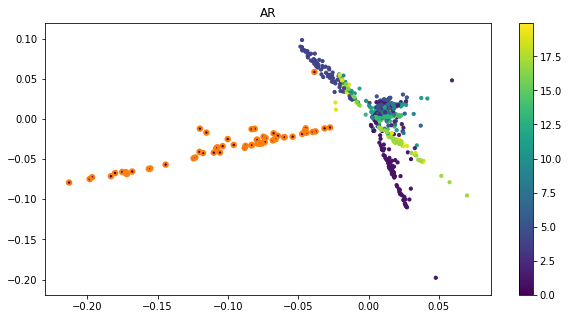

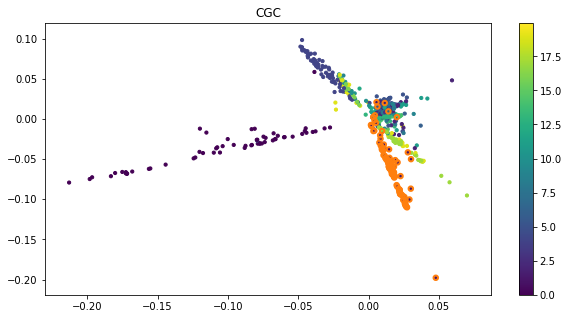

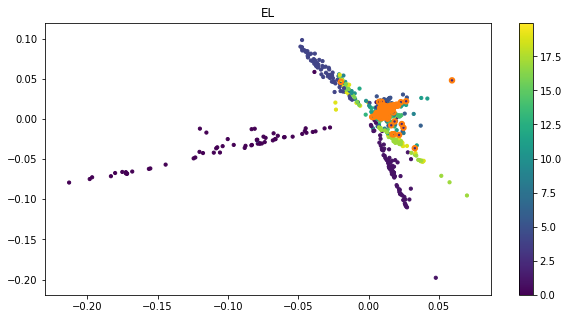

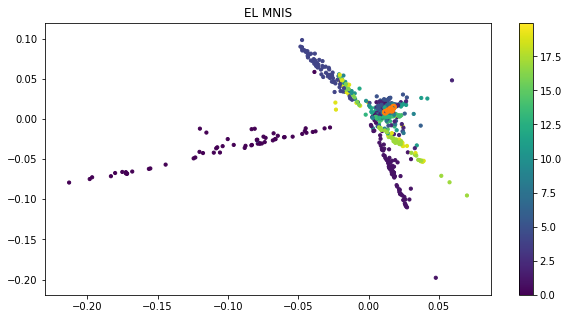

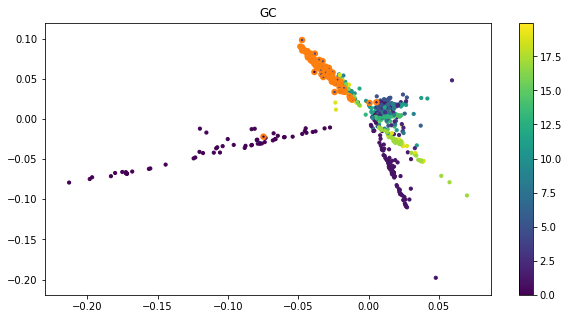

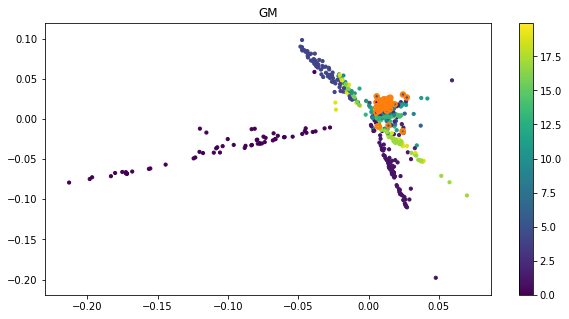

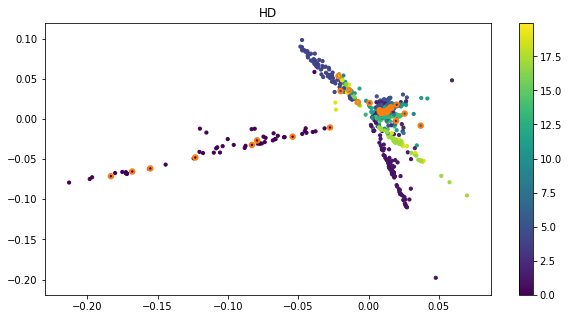

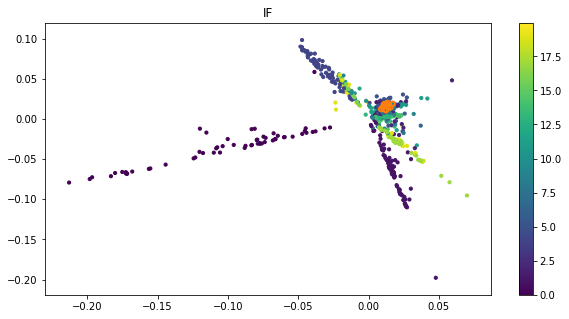

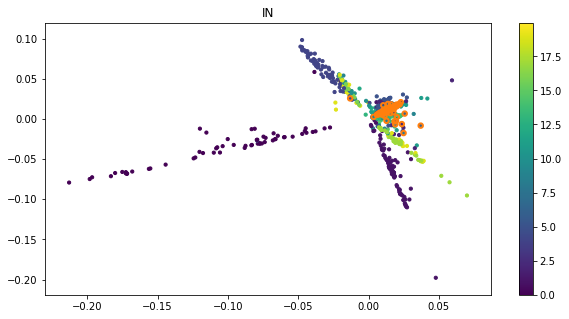

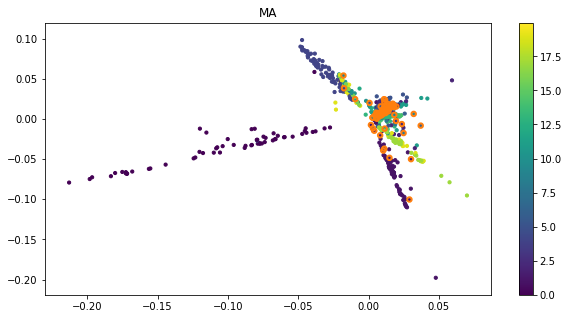

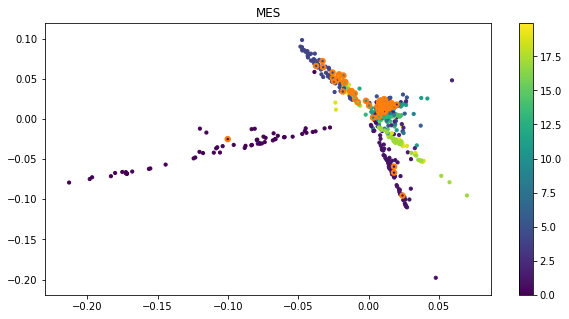

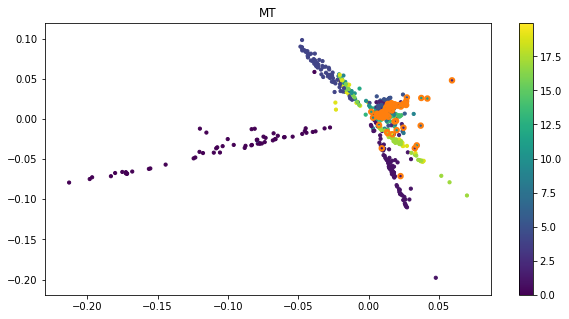

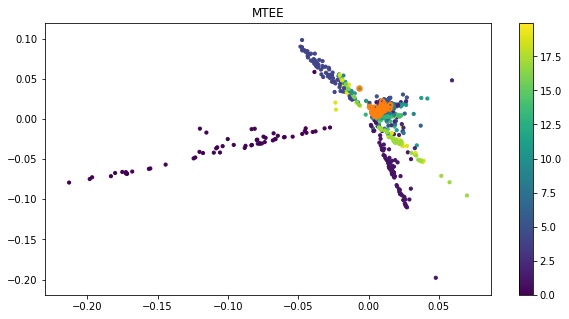

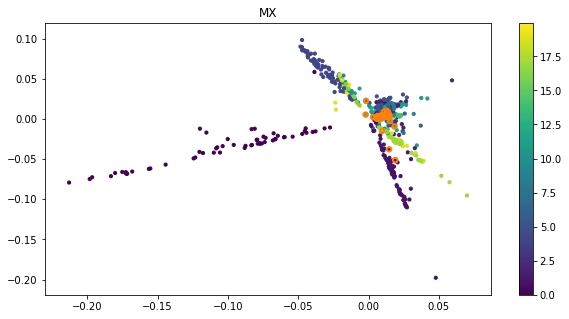

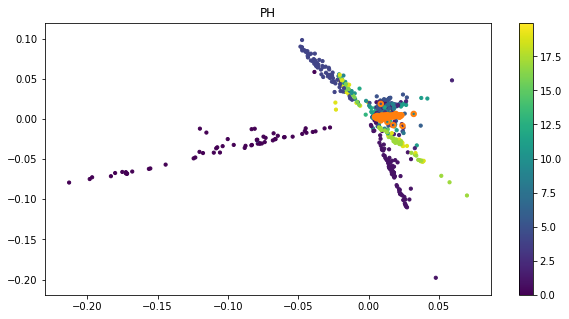

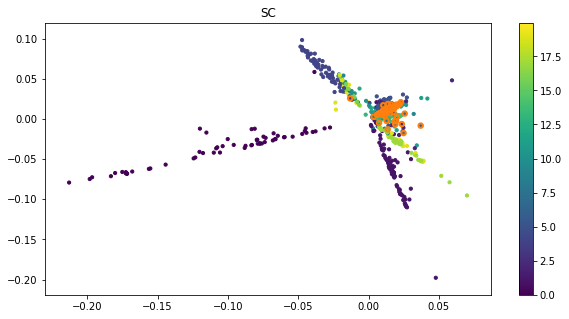

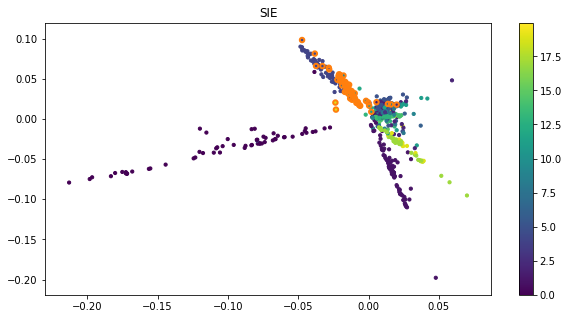

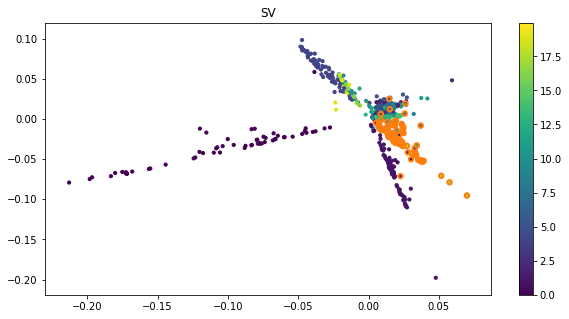

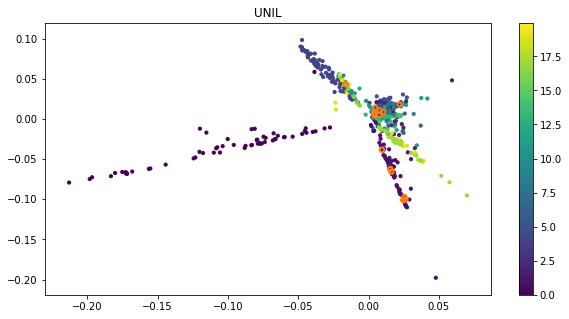

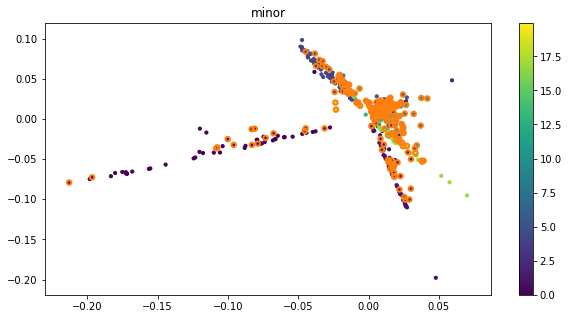

In [19]:
## Study plan
for i in range(len(StudyPlansDisplay)):
    plt.figure()
    G.plot_signal(id_courses_sections_labelAR[:,0], vertex_size=10,plot_name=StudyPlansDisplay[i] , save_as="Graphs/image/student_"+StudyPlansDisplay[i]+"_studyPlan_wAR", highlight=np.where(np.isin(id_courses_sections_labelAR,[i]).any(axis=1)))

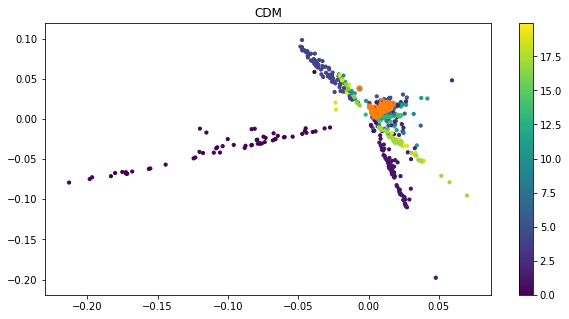

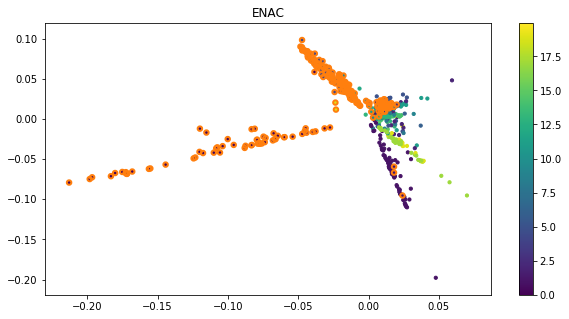

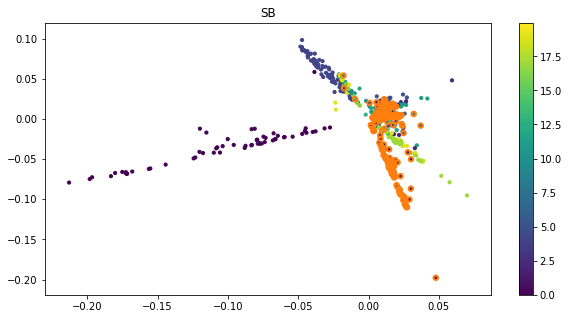

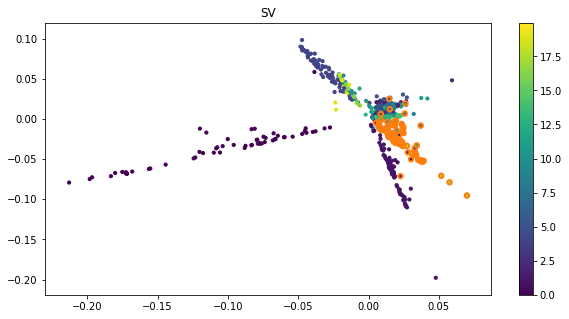

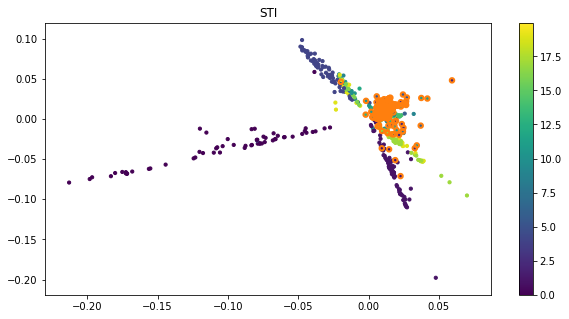

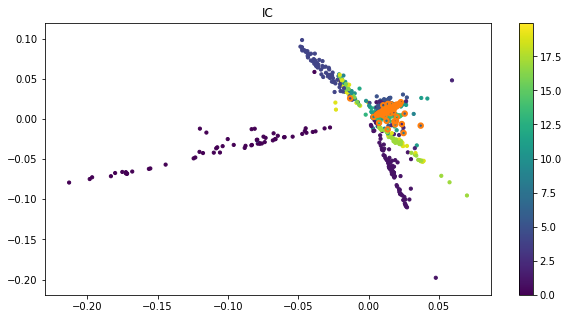

In [17]:
# faculty
for fac,ids in faculties.items():
    plt.figure()
    G.plot_signal(id_courses_sections_labelAR[:,0], vertex_size=10,plot_name=fac, save_as="Graphs/image/student_"+fac+"_faculty_wAR" , highlight=np.where(np.isin(id_courses_sections_labelAR,ids).any(axis=1)))

c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


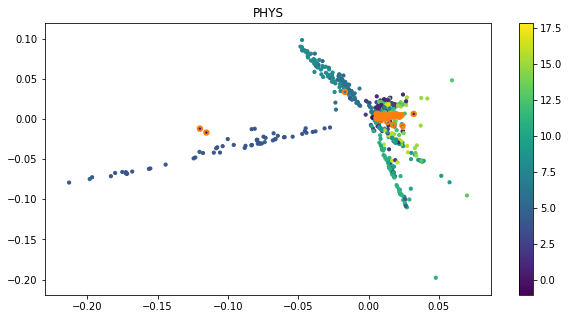

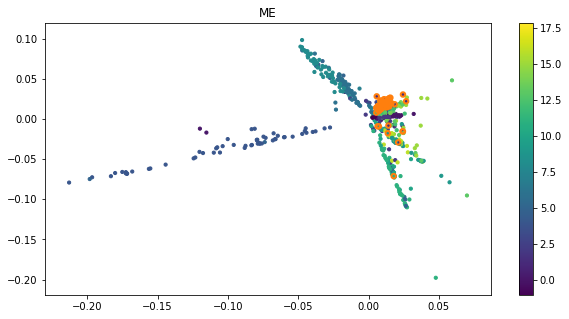

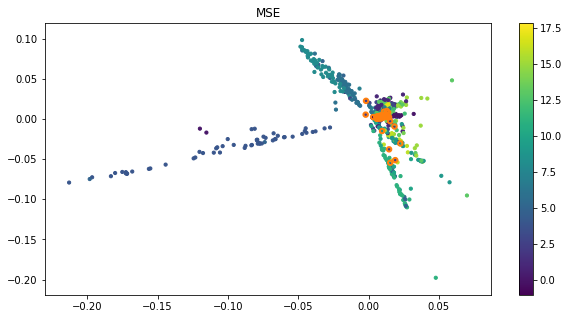

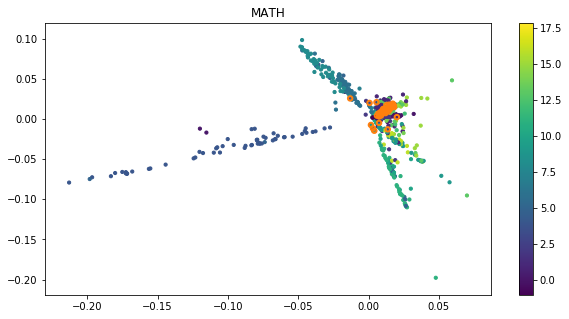

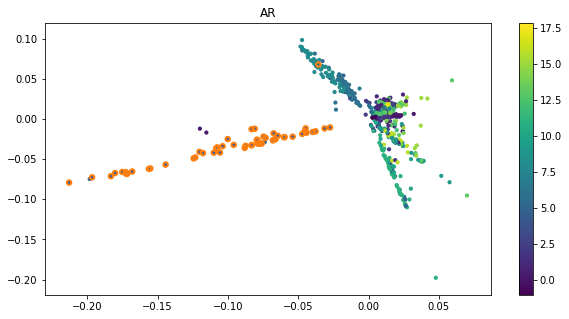

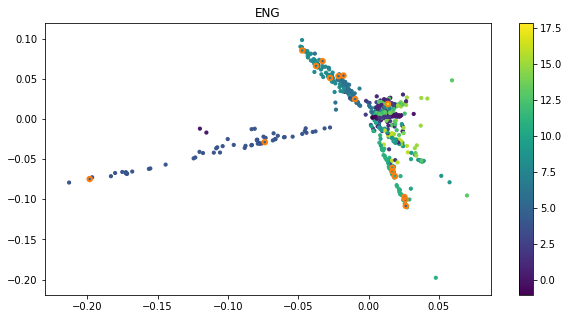

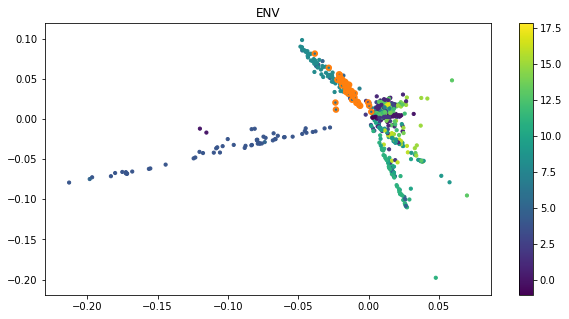

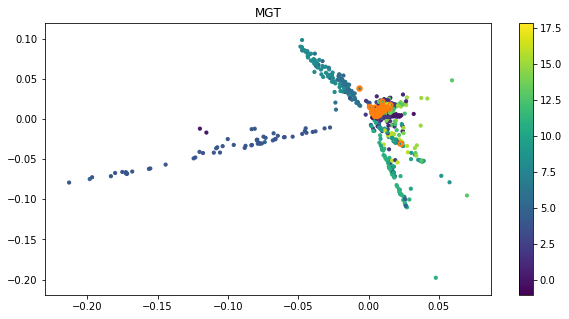

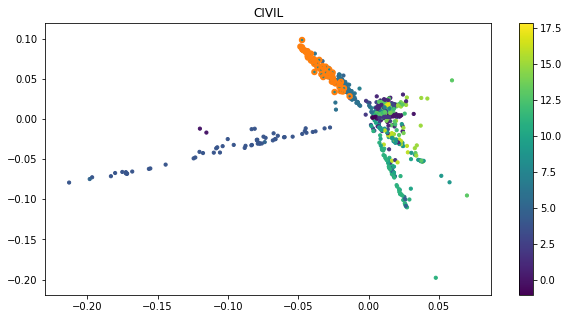

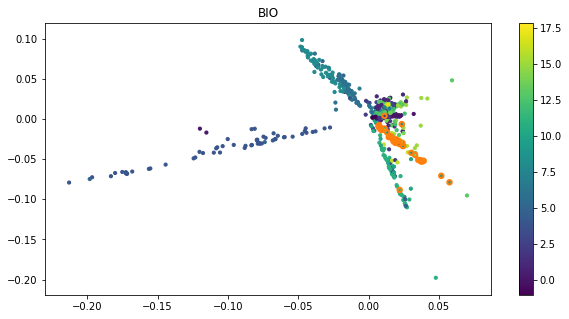

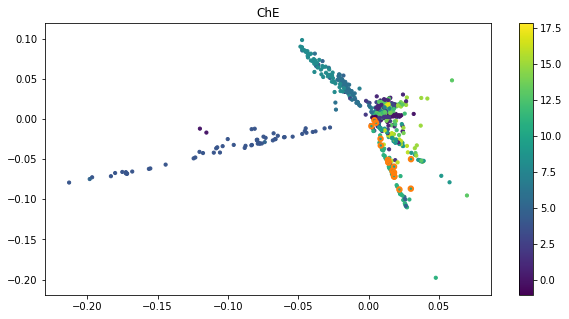

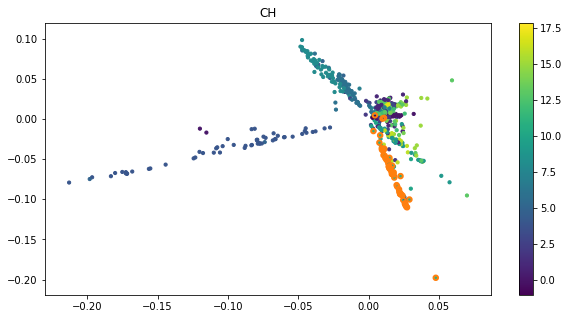

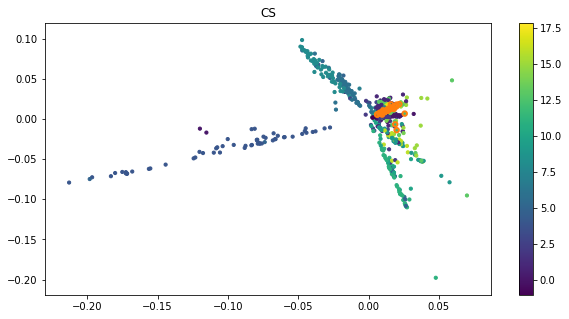

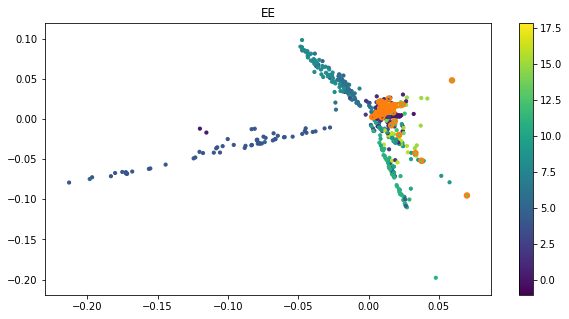

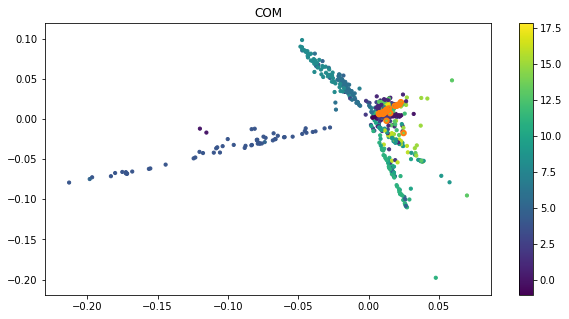

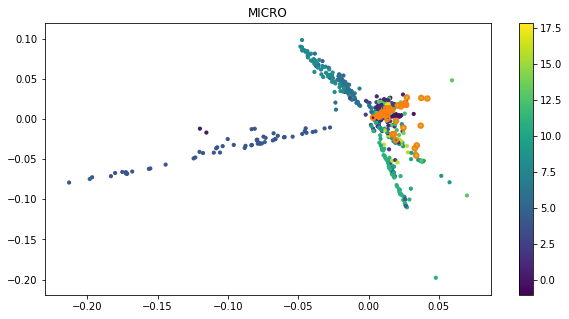

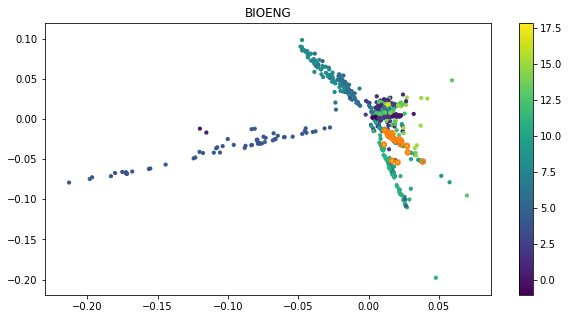

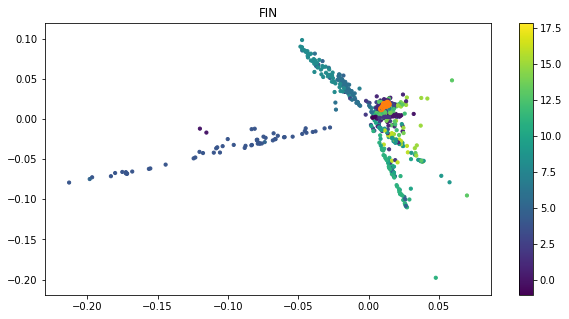

In [31]:
# sections
for i in range(len(courseSection)):
    plt.figure()
    G.plot_signal(id_courses_code_labelAR, vertex_size=10,plot_name=courseSection[i], 
                  save_as="Graphs/image/student_"+courseSection[i]+"_section_wAR", 
                  highlight=np.where(id_courses_code_labelAR==i))

In [23]:
def showAndSaveData(weightMatrix,graphName):
    G1=nx.from_numpy_matrix(weightMatrix)
    # Giant component
    Gcc=sorted(nx.connected_component_subgraphs(G1), key = len, reverse=True)[0]
    print("size of giant component: "+str(len(Gcc)))
    # weight distribution
    plt.hist(list(nx.degree(G1).values()))
    plt.title("weight distribution")
    plt.savefig("Graphs/image/"+graphName+"_weightDistrib")
    plt.figure()
    # weight matrix
    plt.title("weight matrix")
    plt.spy(weightMatrix)
    plt.savefig("Graphs/image/"+graphName+"_weightMatrix")

size of giant component: 798


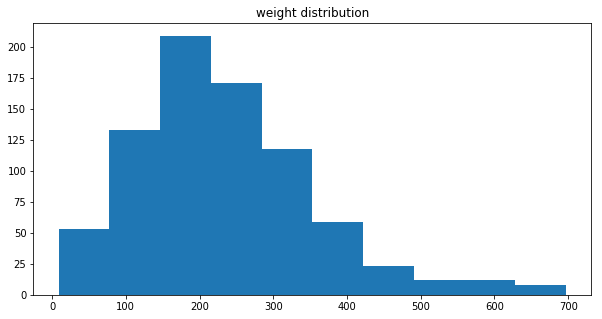

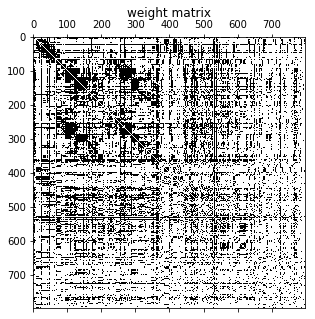

In [39]:
showAndSaveData(weight_student_AR,"student_AR")

### 2.2.2 Graph Student - without AR

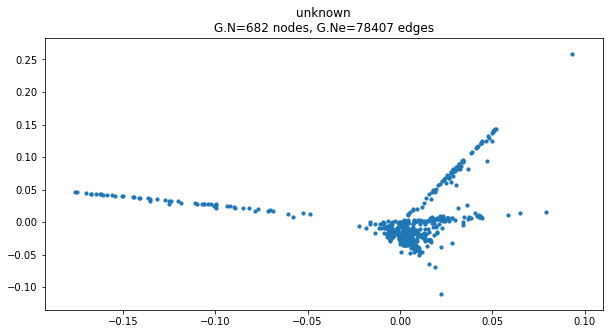

In [49]:
G=graphs.Graph(weight_student)
laplacian=G.compute_laplacian("normalized")
G.compute_fourier_basis(recompute=True)
G.set_coordinates(G.U[:,1:3])
G.plot(vertex_size=10)#show_edges=True, vertex_size=10)

c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


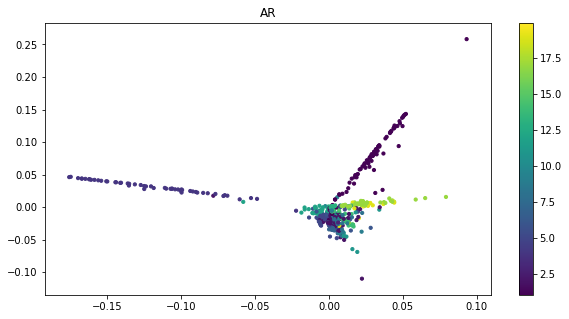

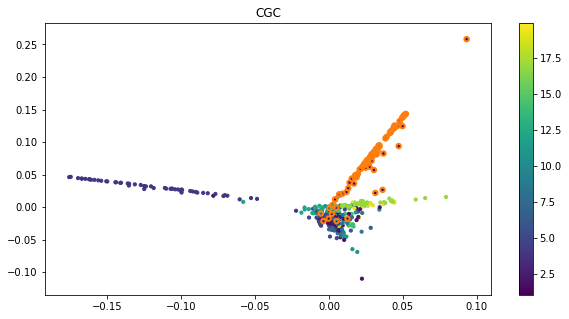

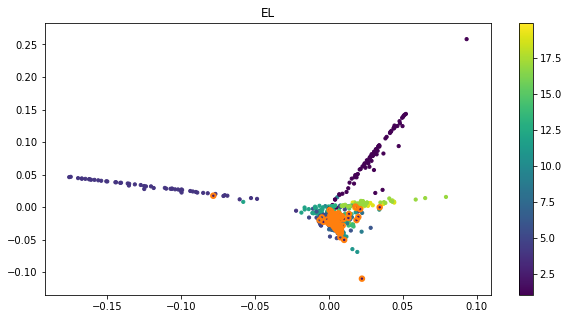

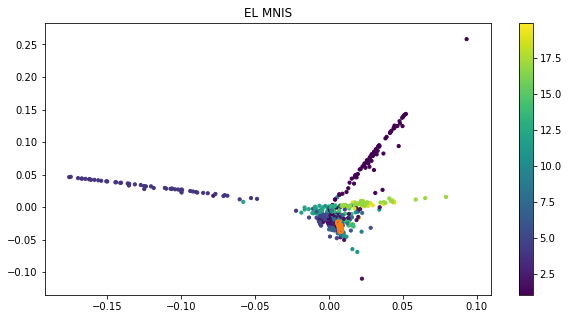

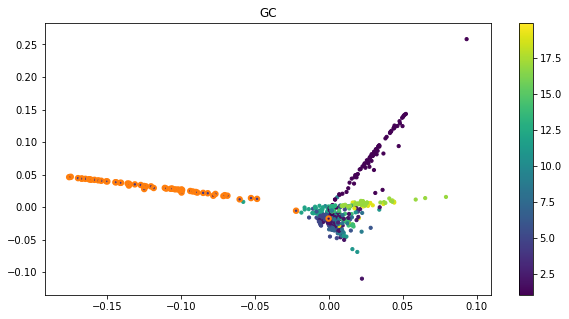

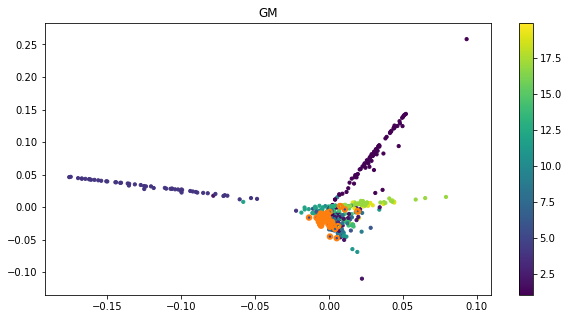

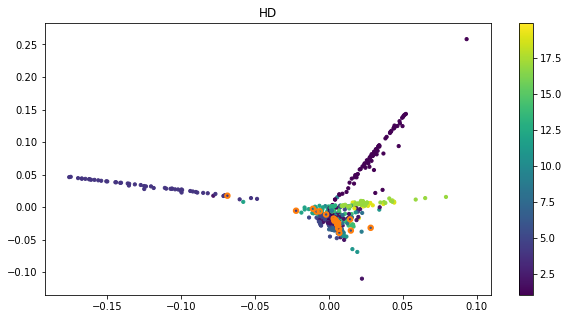

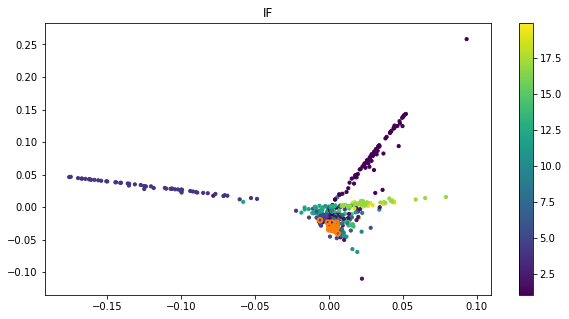

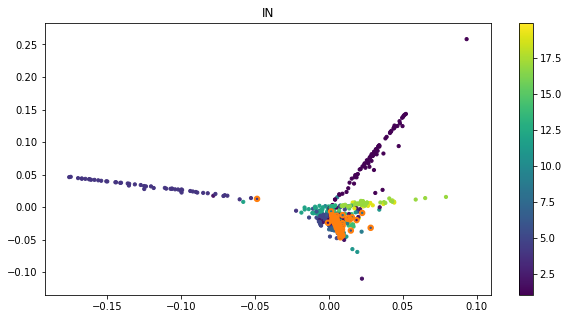

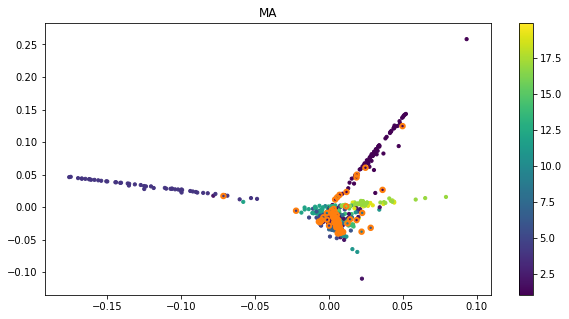

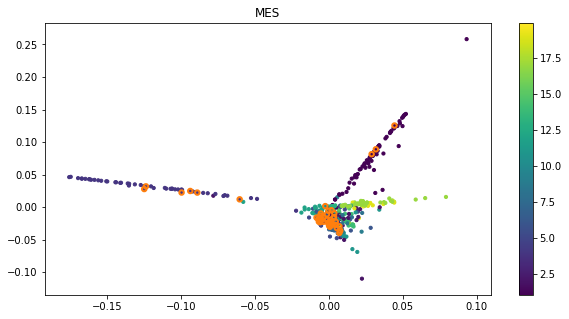

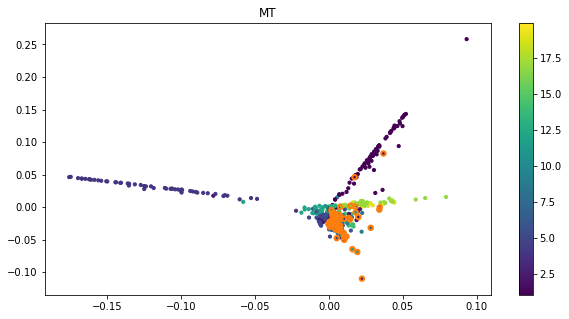

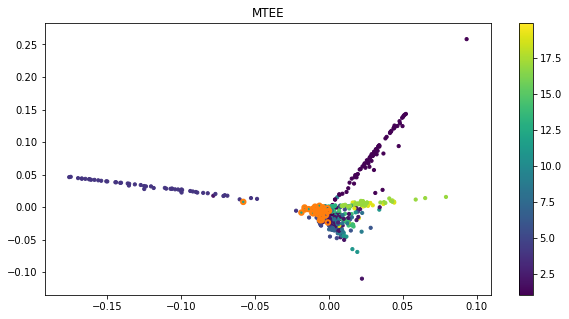

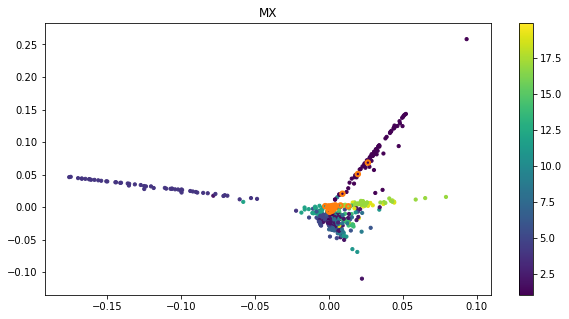

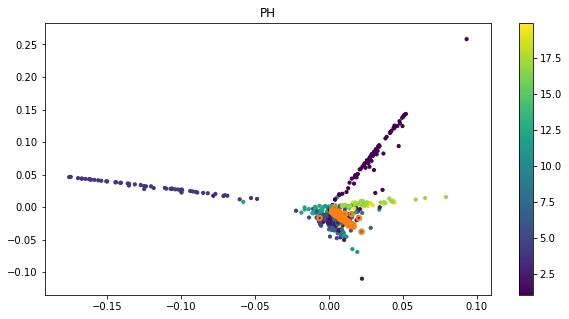

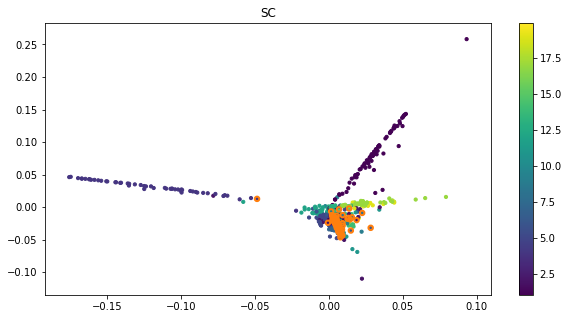

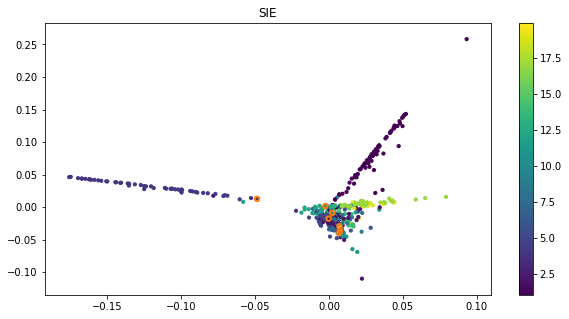

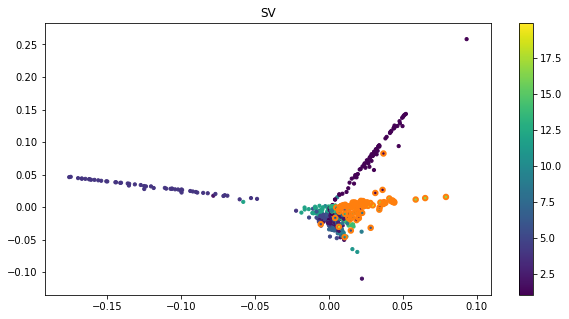

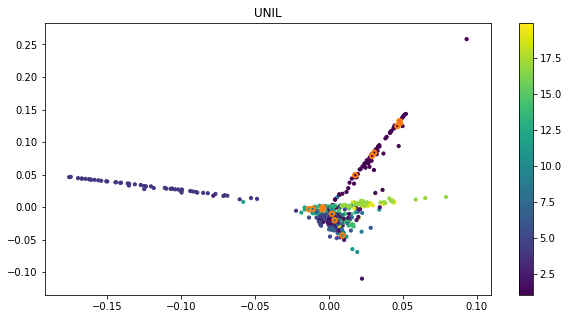

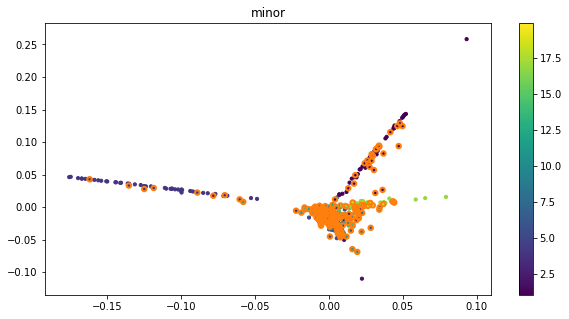

In [50]:
## Study plan
for i in range(len(StudyPlansDisplay)):
    plt.figure()
    G.plot_signal(id_courses_sections_label[:,0], vertex_size=10,plot_name=StudyPlansDisplay[i] , save_as="Graphs/image/student_"+StudyPlansDisplay[i]+"_studyPlan", highlight=np.where(np.isin(id_courses_sections_label,[i]).any(axis=1)))

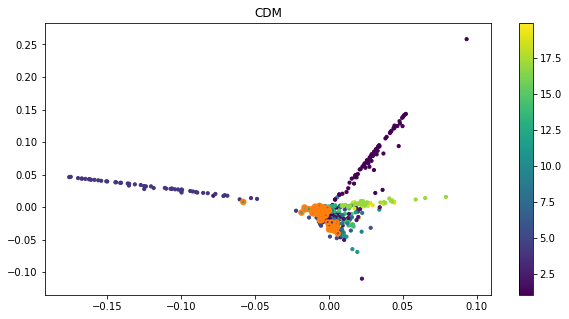

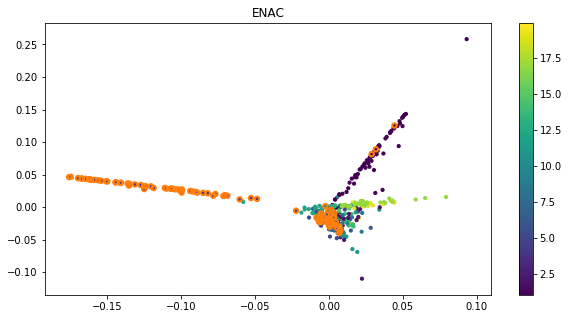

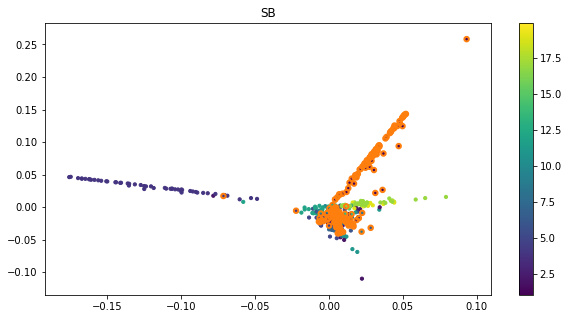

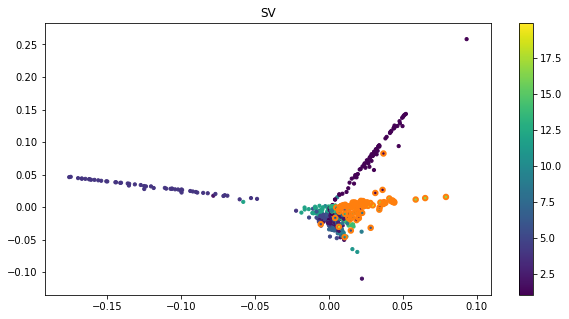

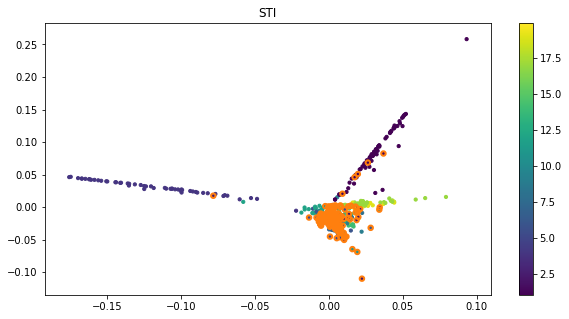

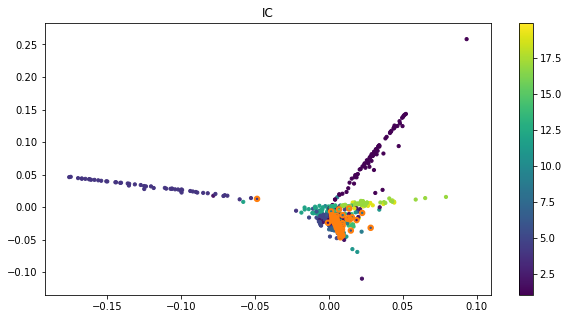

In [51]:
# faculty
for fac,ids in faculties.items():
    plt.figure()
    G.plot_signal(id_courses_sections_label[:,0], vertex_size=10,plot_name=fac, save_as="Graphs/image/student_"+fac+"_faculty" , highlight=np.where(np.isin(id_courses_sections_label,ids).any(axis=1)))

c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


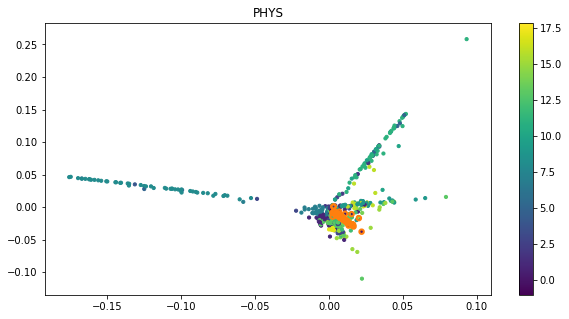

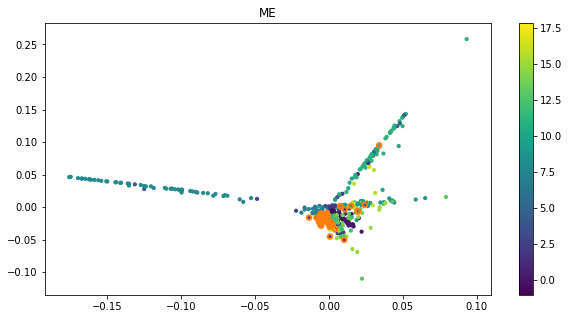

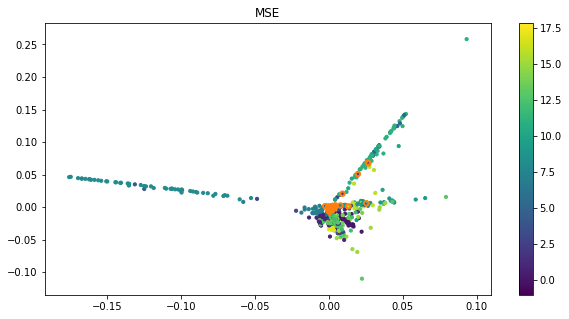

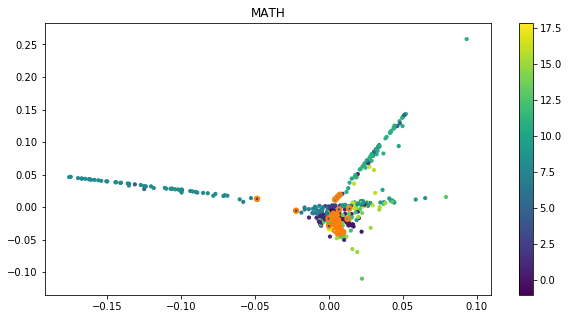

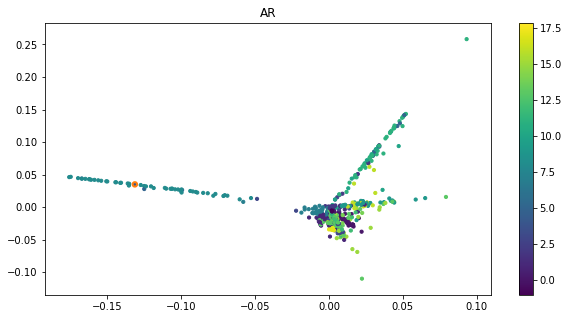

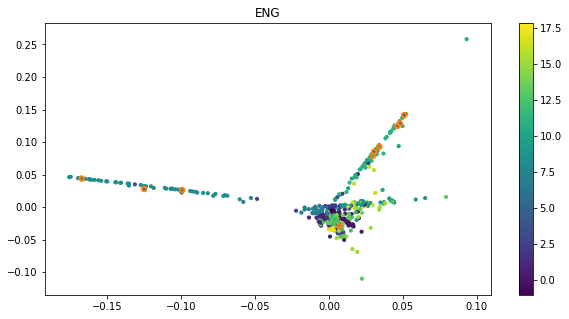

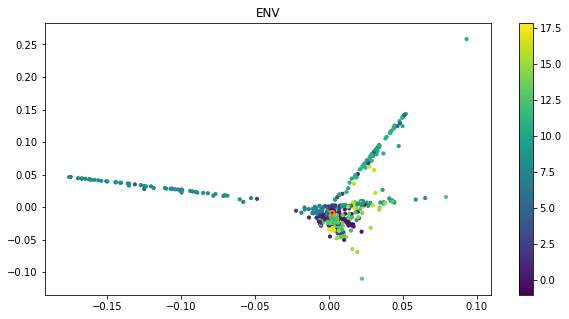

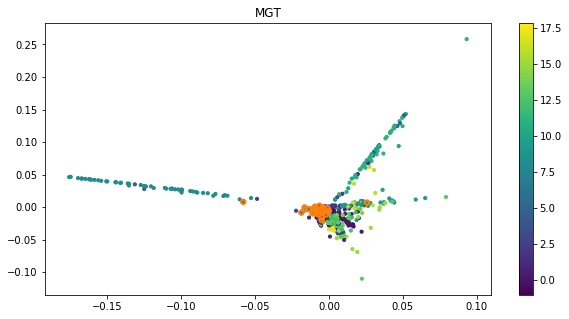

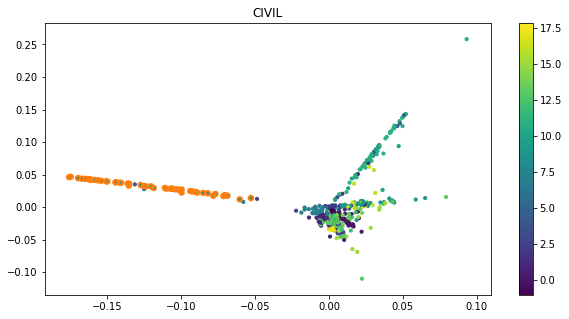

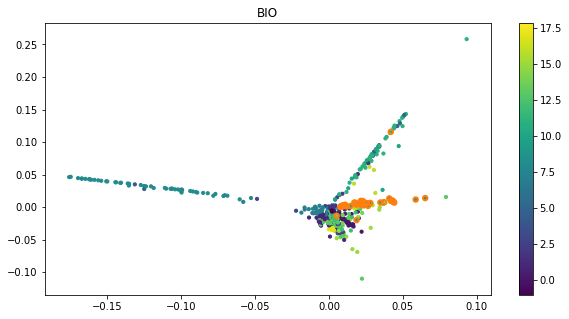

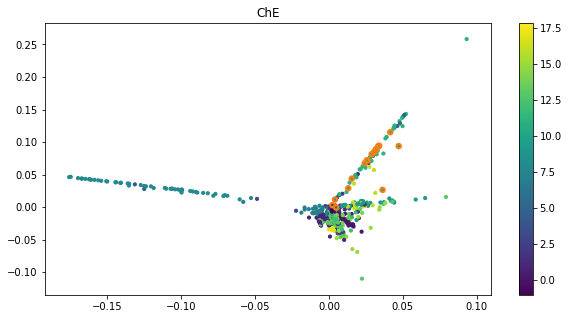

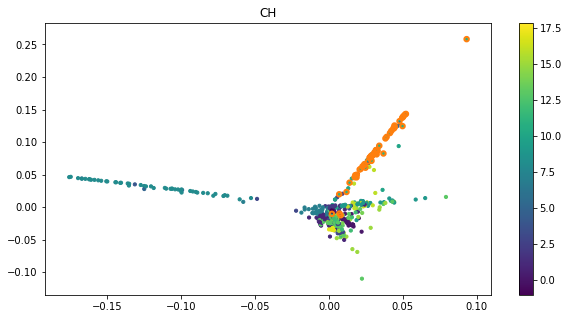

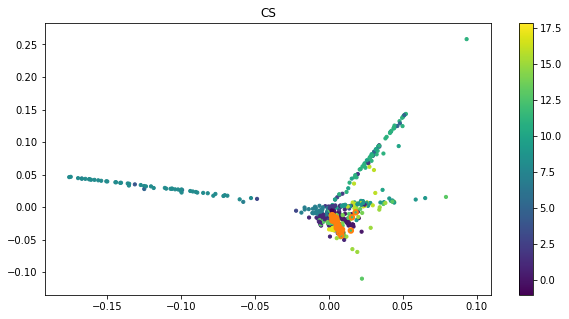

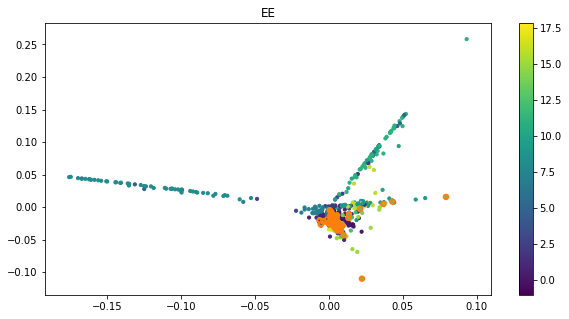

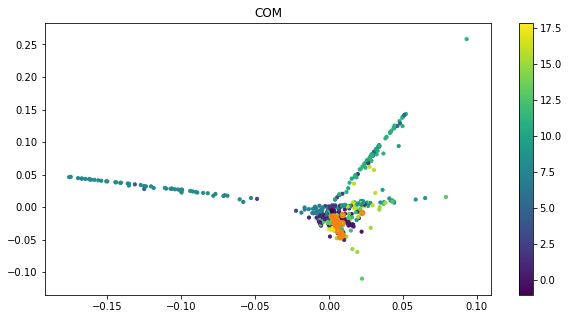

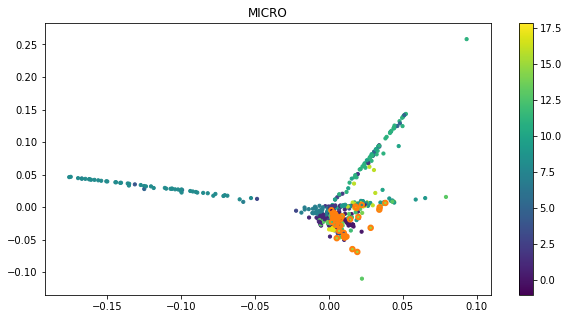

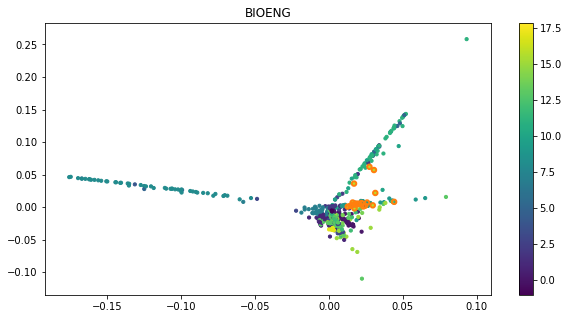

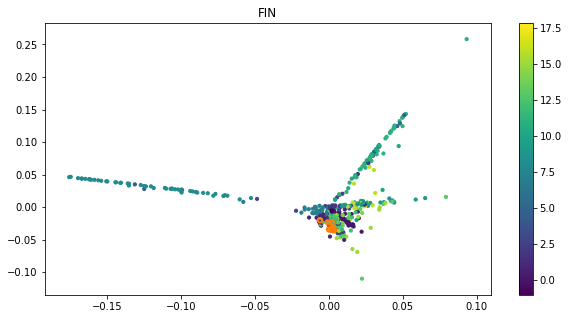

In [52]:
# sections
for i in range(len(courseSection)):
    plt.figure()
    G.plot_signal(id_courses_code_label, vertex_size=10,plot_name=courseSection[i], 
                  save_as="Graphs/image/student_"+courseSection[i]+"_section", 
                  highlight=np.where(id_courses_code_label==i))

size of giant component: 682


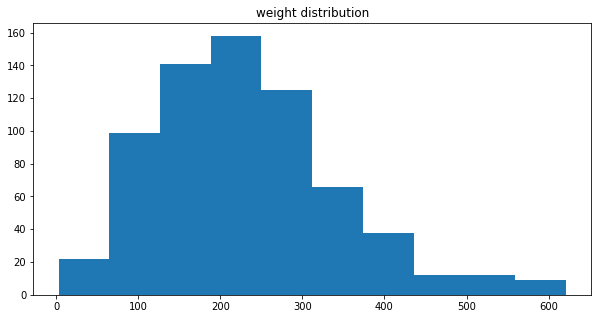

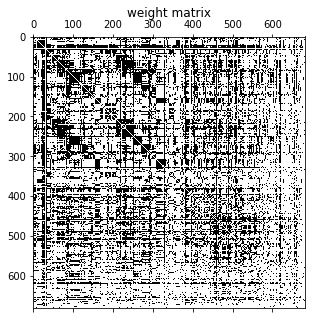

In [53]:
showAndSaveData(weight_student,"student")

### 2.2.3 Graph Student - master STI

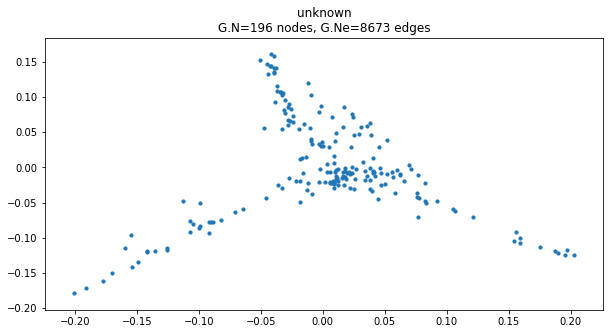

In [21]:
G=graphs.Graph(weight_student_STI)
laplacian=G.compute_laplacian("normalized")
G.compute_fourier_basis(recompute=True)
G.set_coordinates(G.U[:,1:3])
G.plot(vertex_size=10,show_edges=False)

size of giant component: 196


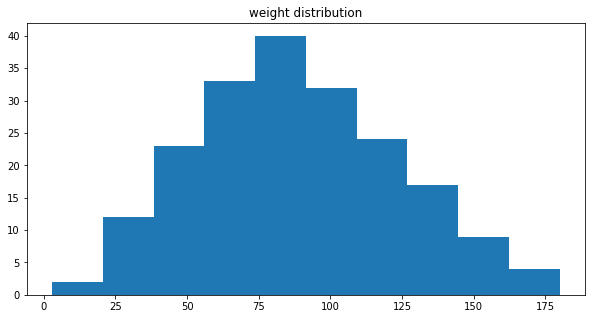

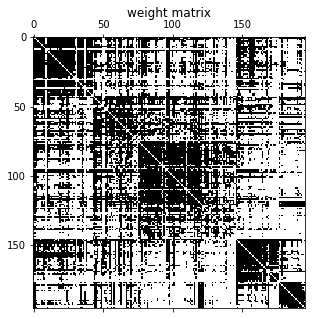

In [25]:
showAndSaveData(weight_student_STI,"student_STI_weight")

 50%|█████████████████████████████████████████                                         | 10/20 [00:02<00:02,  4.22it/s]c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.31it/s]


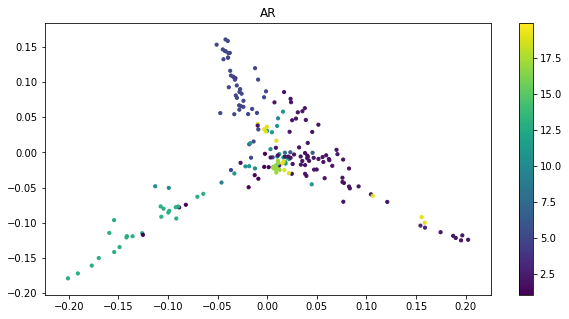

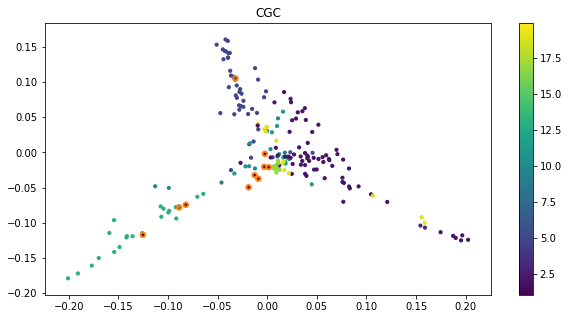

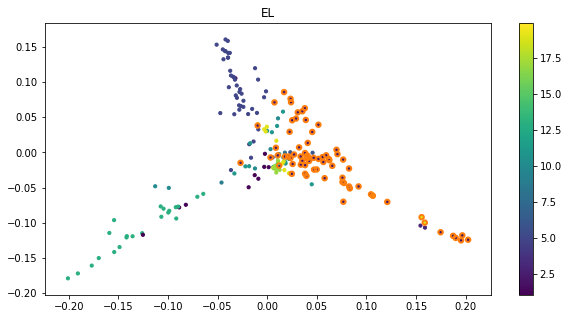

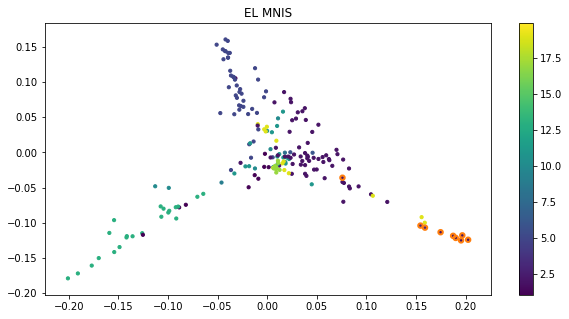

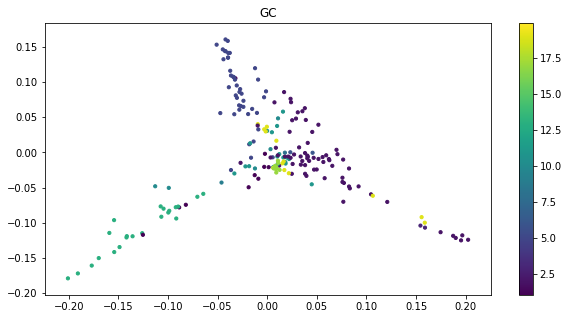

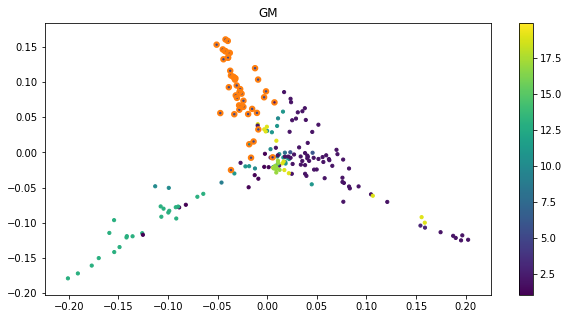

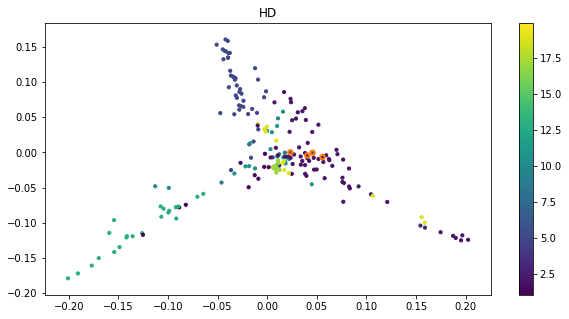

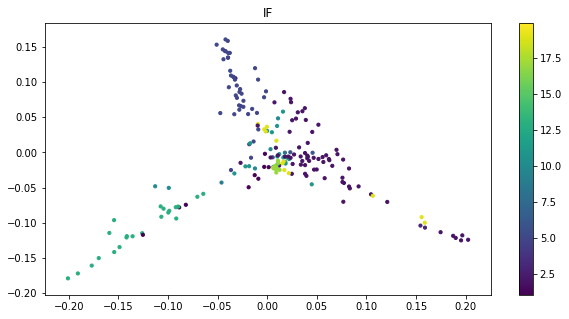

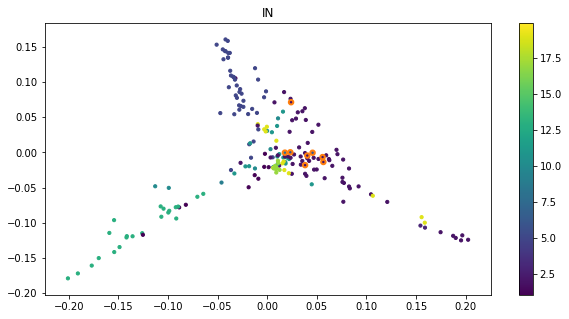

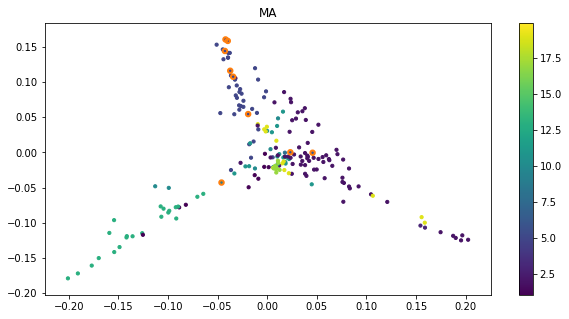

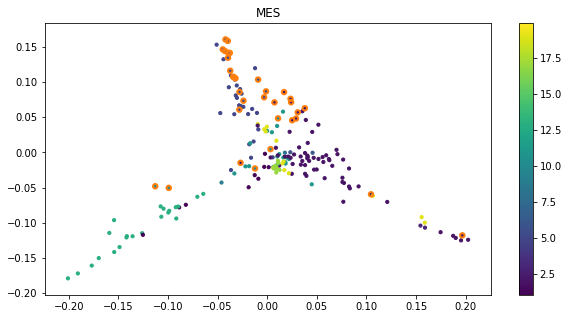

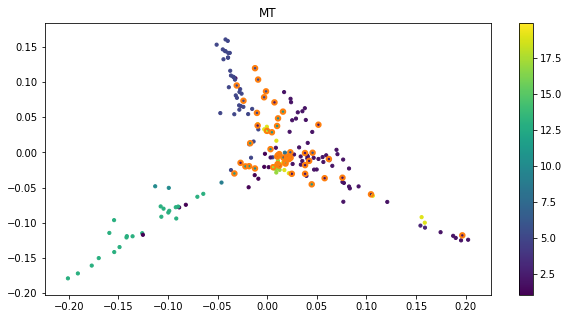

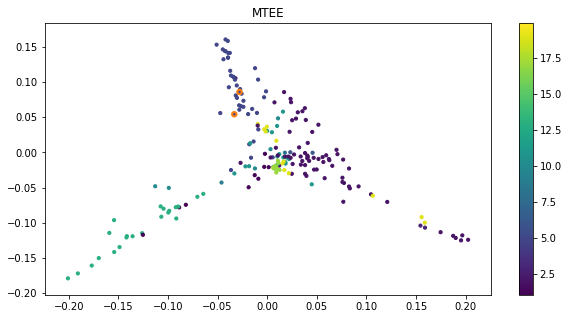

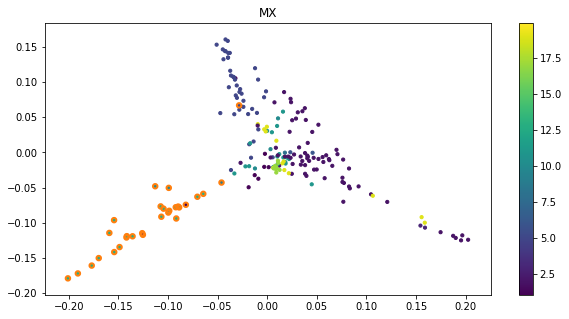

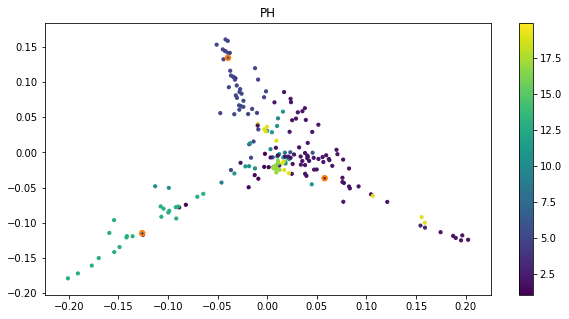

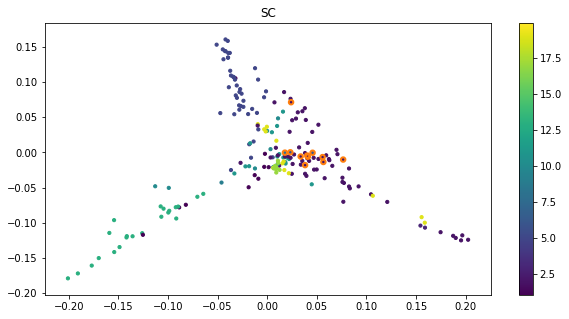

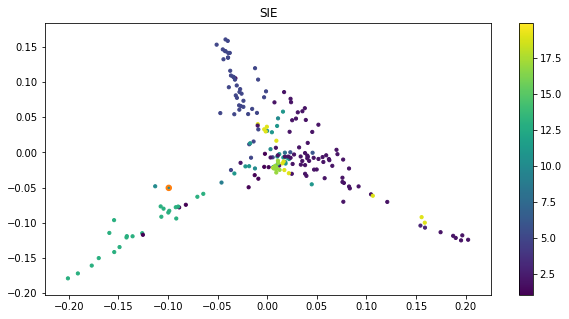

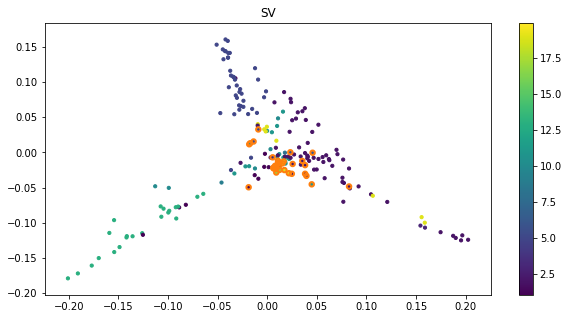

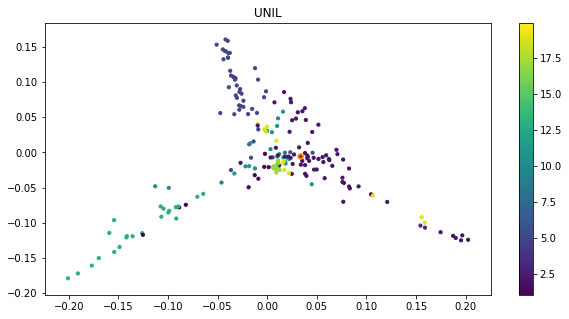

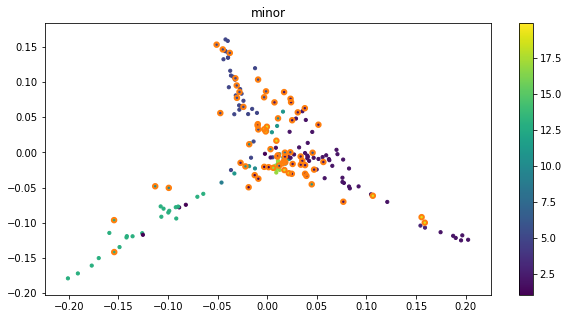

In [47]:
## Study plan
for i in tqdm(range(len(StudyPlansDisplay))):
    plt.figure()
    G.plot_signal(id_courses_sections_labelSTI[:,0],show_edges=False, vertex_size=10,plot_name=StudyPlansDisplay[i] , save_as="Graphs/image/student_"+StudyPlansDisplay[i]+"_studyPlan_wSTI", highlight=np.where(np.isin(id_courses_sections_labelSTI,[i]).any(axis=1)))

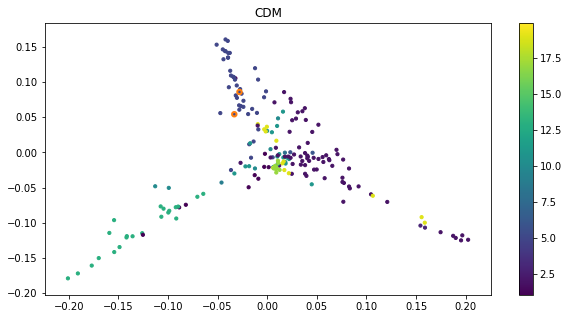

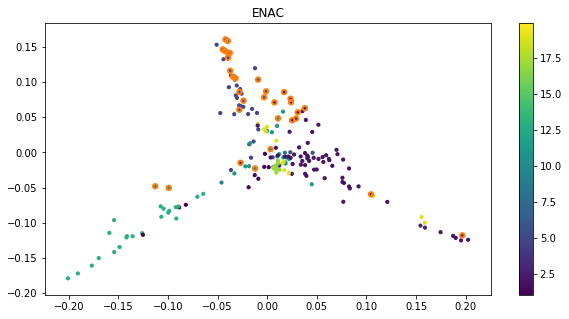

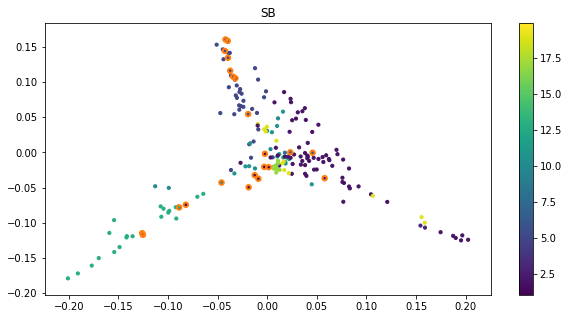

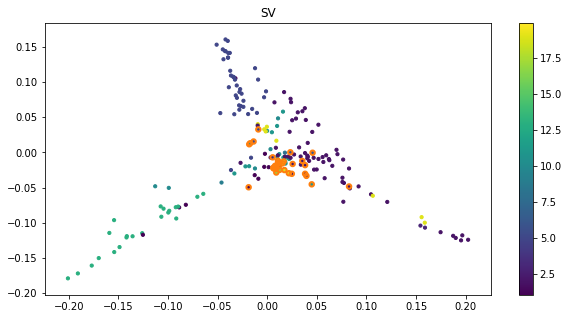

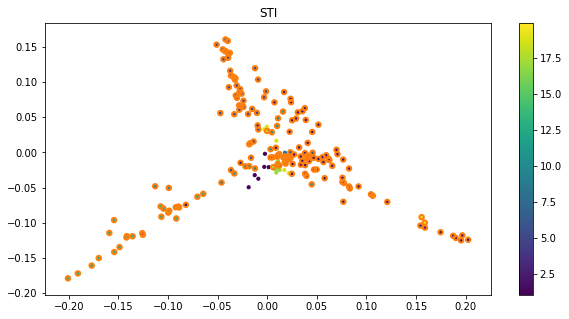

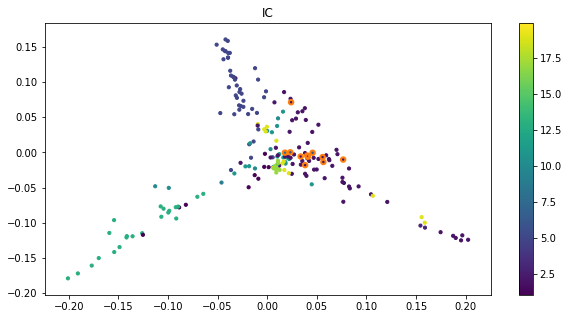

In [58]:
# faculty
for fac,ids in faculties.items():
    plt.figure()
    G.plot_signal(id_courses_sections_labelSTI[:,0],show_edges=False, vertex_size=10,plot_name=fac, save_as="Graphs/image/student_"+fac+"_faculty_STI" , highlight=np.where(np.isin(id_courses_sections_labelSTI,ids).any(axis=1)))

c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


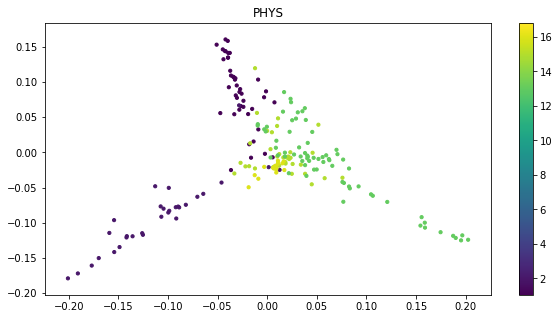

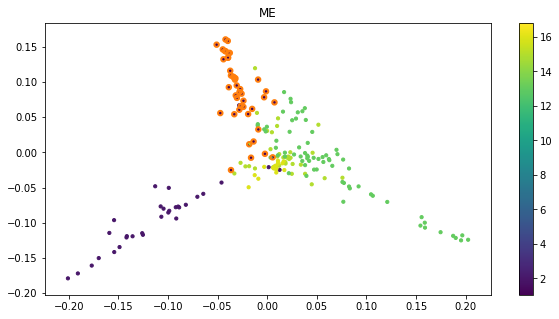

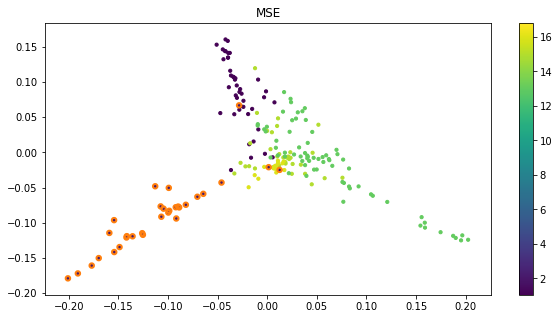

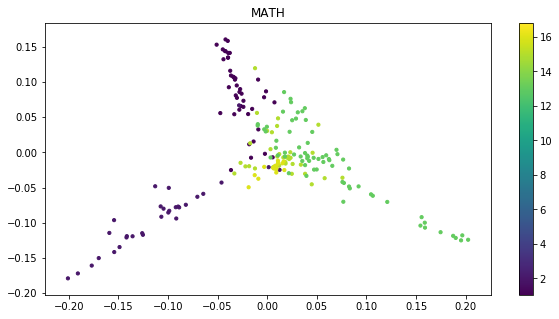

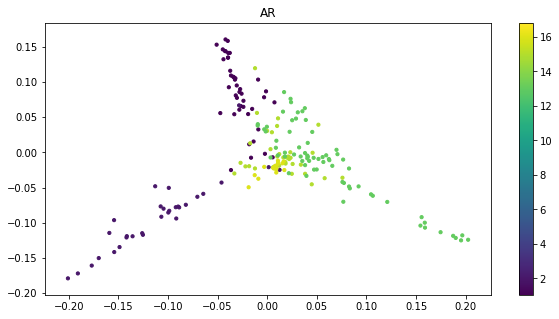

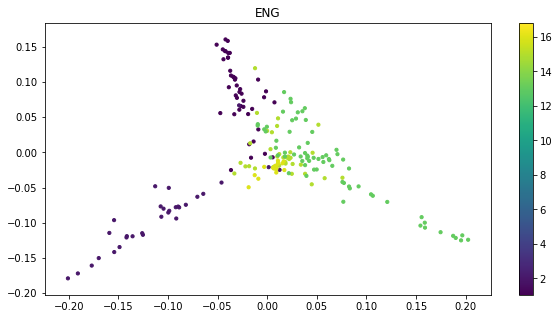

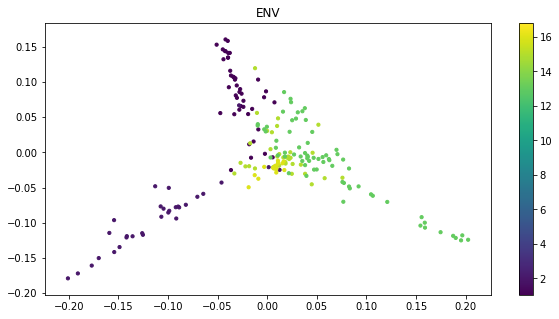

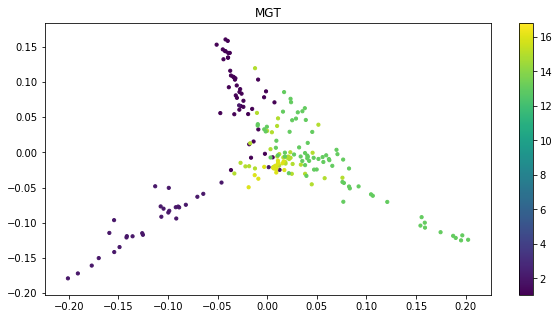

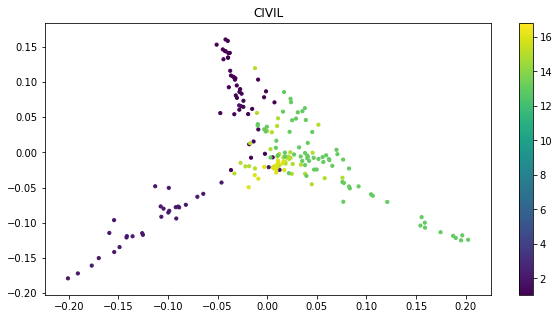

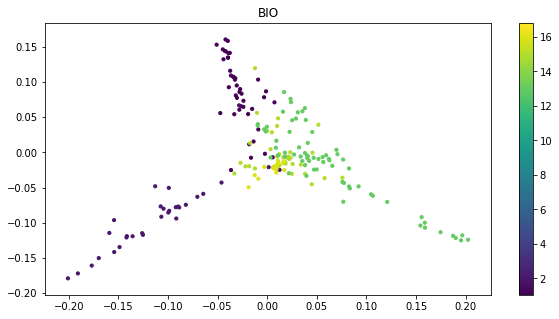

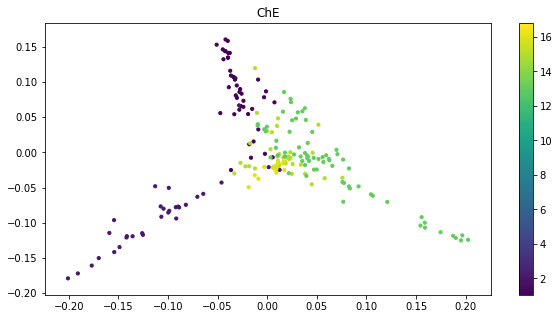

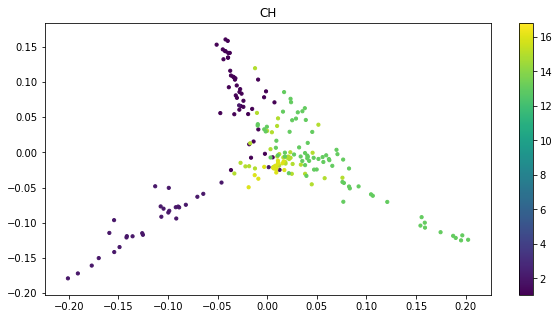

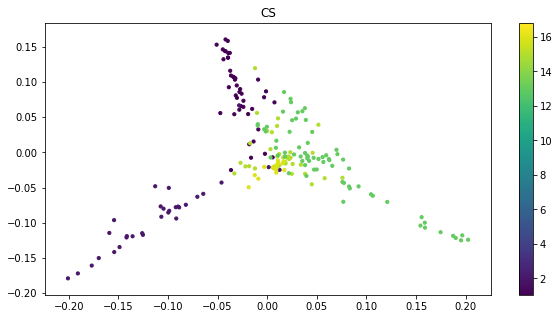

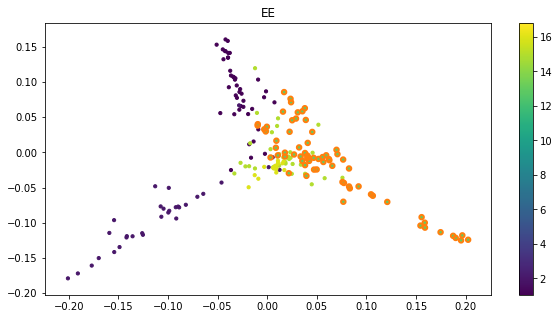

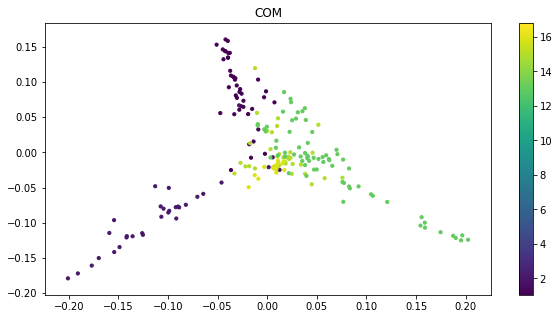

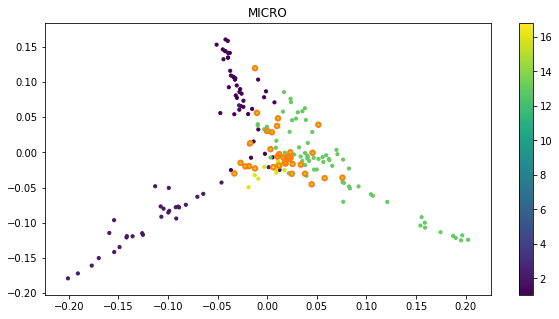

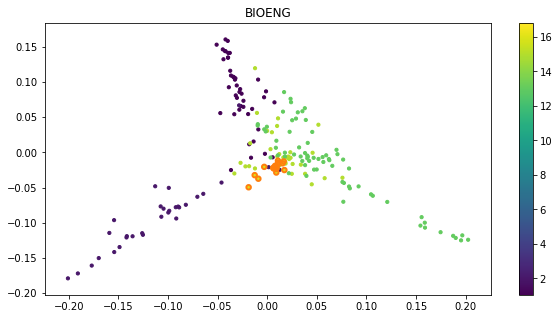

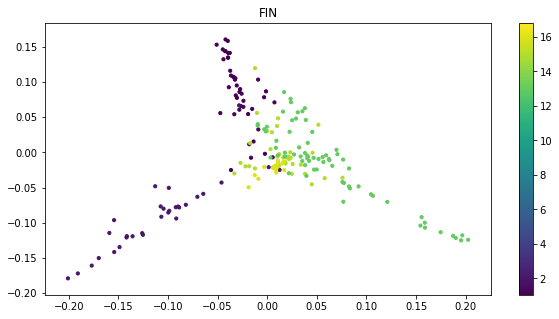

In [56]:
# sections
for i in range(len(courseSection)):
    plt.figure()
    G.plot_signal(id_courses_code_labelSTI,show_edges=False, vertex_size=10,plot_name=courseSection[i], 
                  save_as="Graphs/image/student_"+courseSection[i]+"_section_STI", 
                  highlight=np.where(id_courses_code_labelSTI==i))

size of giant component: 196


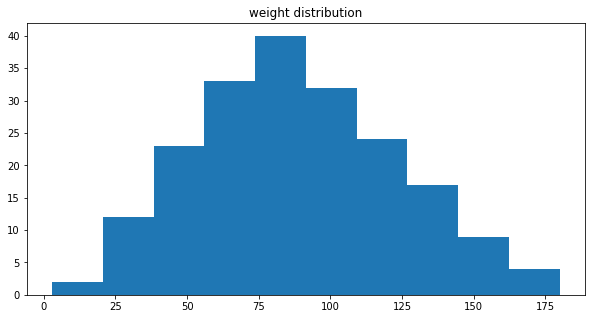

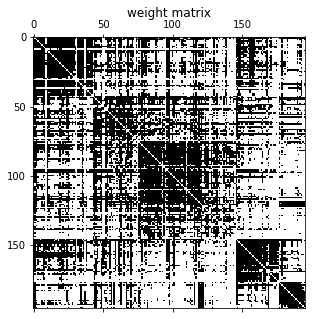

In [57]:
showAndSaveData(weight_student_STI,"student_STI")

### 2.2.4 Graph sections - all sections

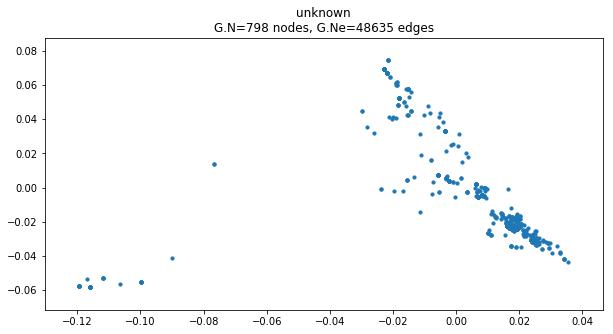

In [59]:
H=graphs.Graph(weight_section_AR)
H.compute_laplacian("normalized")
H.compute_fourier_basis(recompute=True)
H.set_coordinates(H.U[:,1:3])
H.plot(vertex_size=10)

 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  2.84it/s]c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.97it/s]


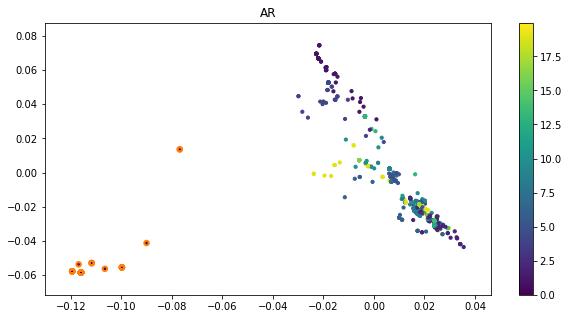

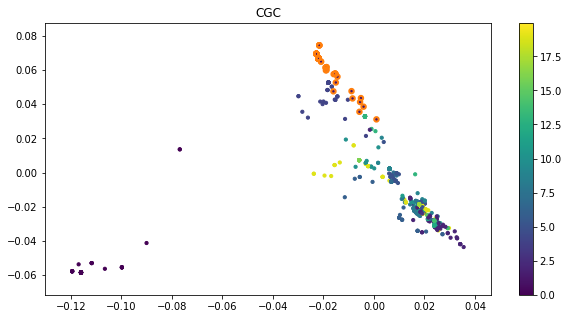

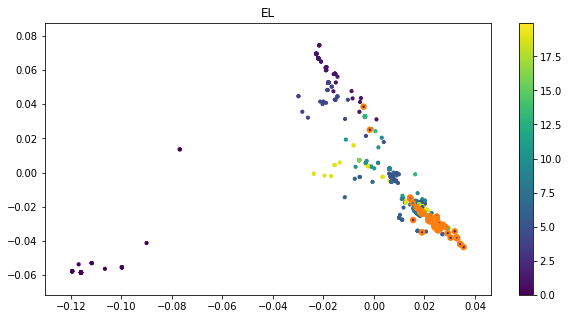

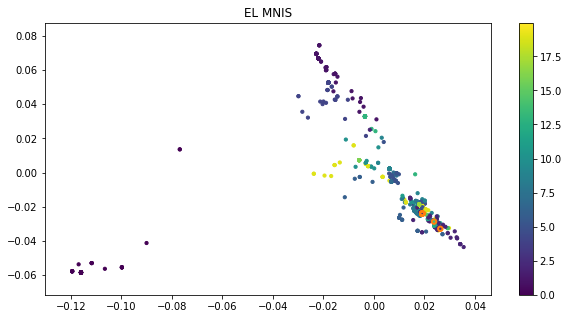

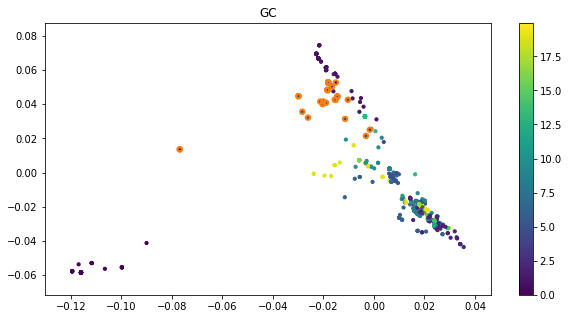

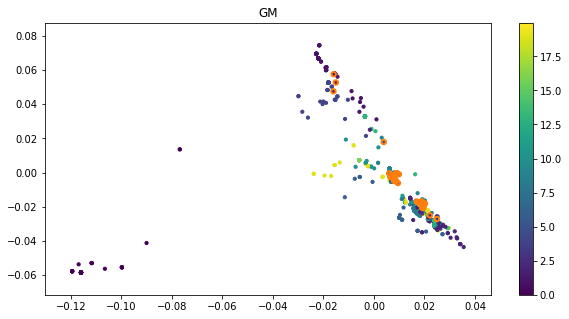

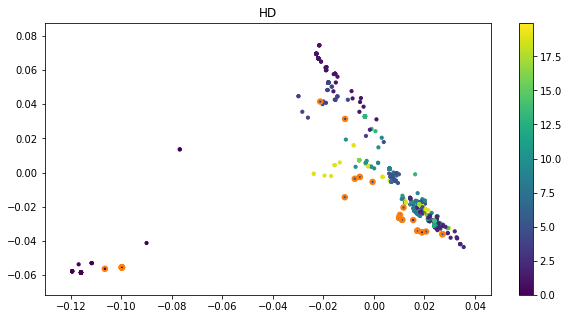

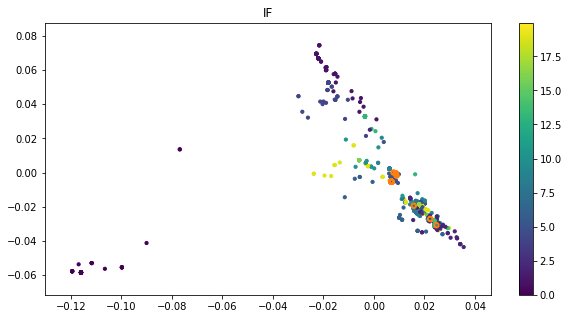

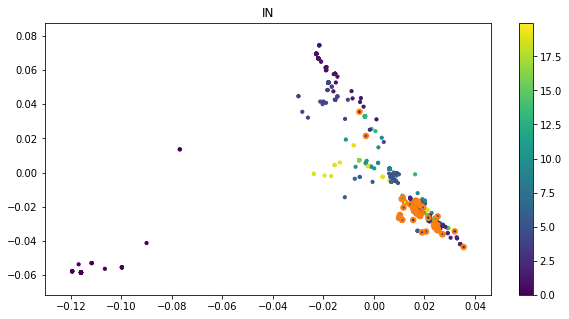

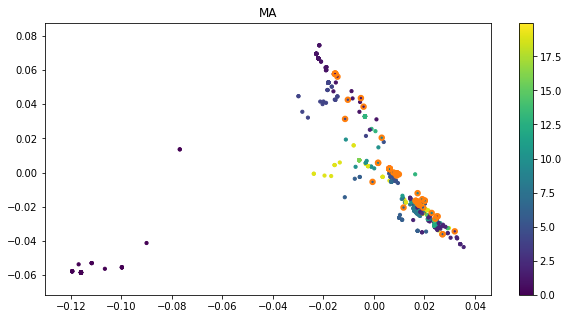

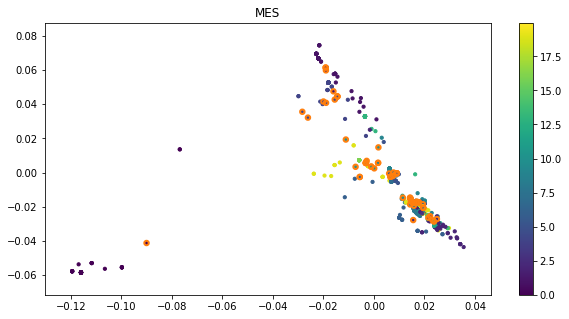

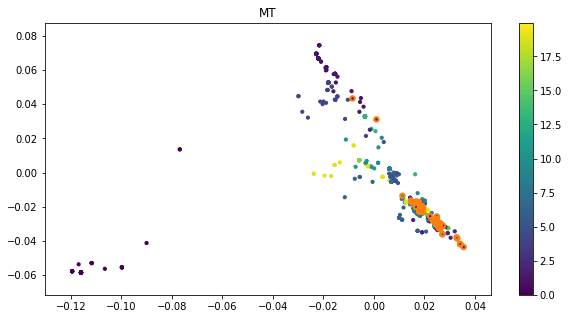

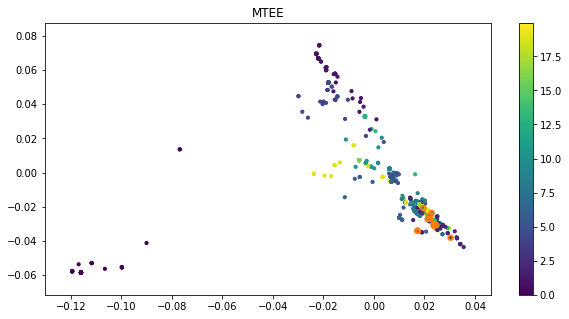

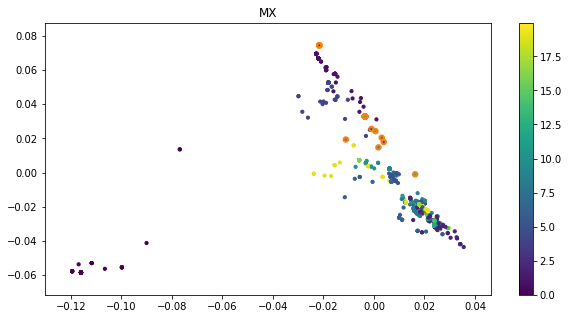

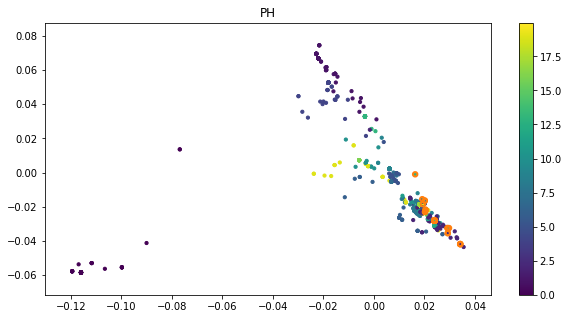

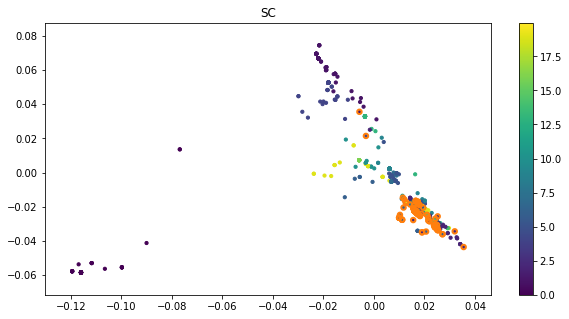

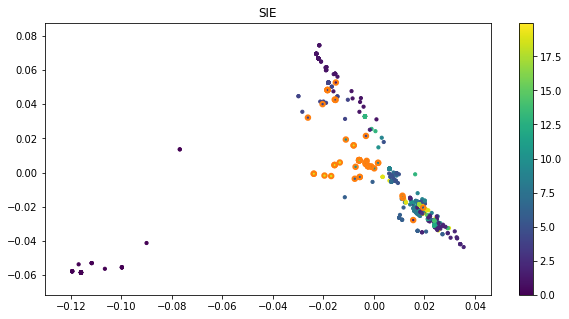

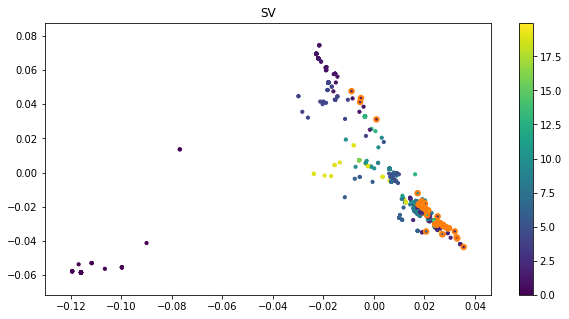

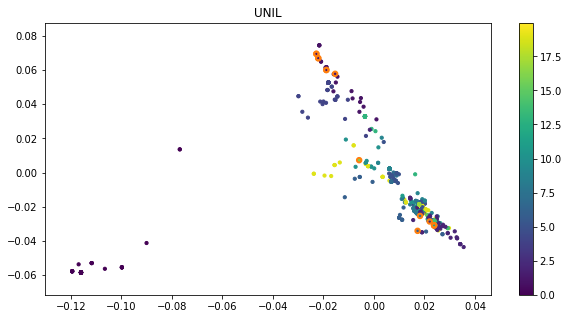

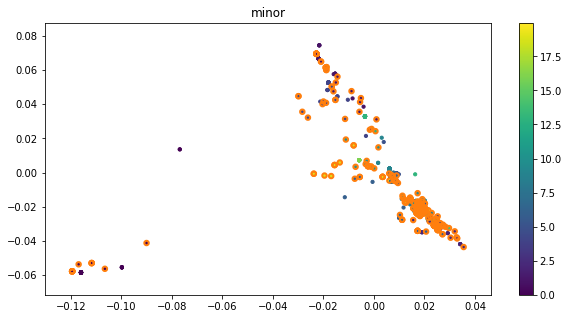

In [60]:
## Study plan
for i in tqdm(range(len(StudyPlansDisplay))):
    plt.figure()
    H.plot_signal(id_courses_sections_labelAR[:,0],show_edges=False, vertex_size=10,plot_name=StudyPlansDisplay[i] , save_as="Graphs/image/section_"+StudyPlansDisplay[i]+"_studyPlan_wAR", highlight=np.where(np.isin(id_courses_sections_labelAR,[i]).any(axis=1)))

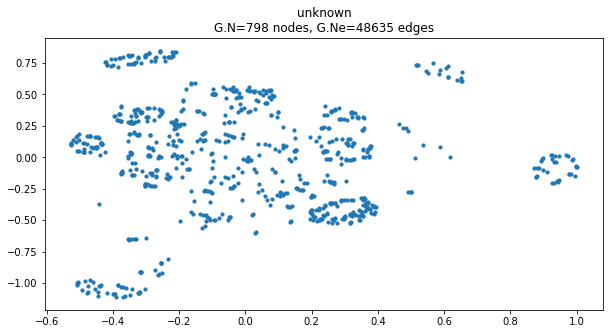

In [61]:
H.set_coordinates('spring')
H.plot(vertex_size=10)

 50%|█████████████████████████████████████████                                         | 10/20 [00:03<00:03,  3.08it/s]c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:06<00:00,  2.96it/s]


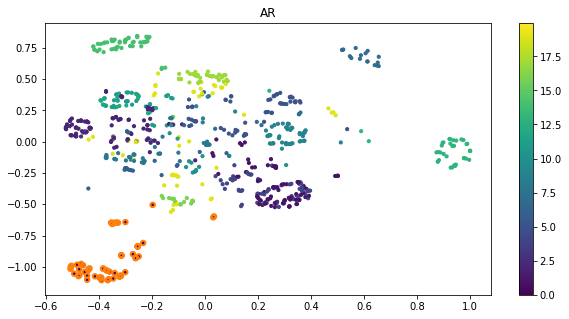

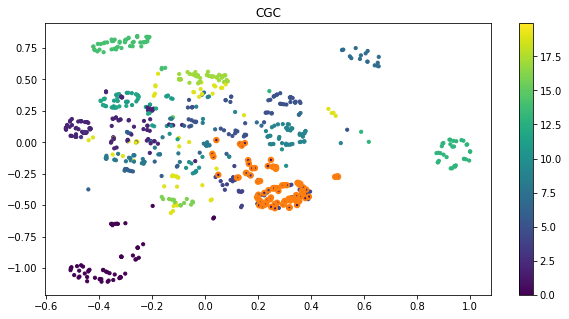

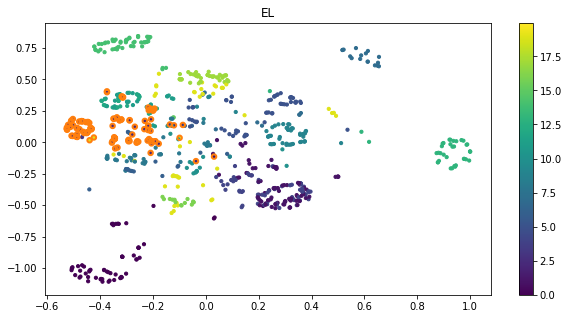

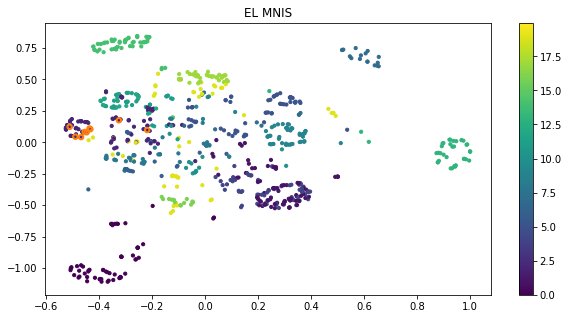

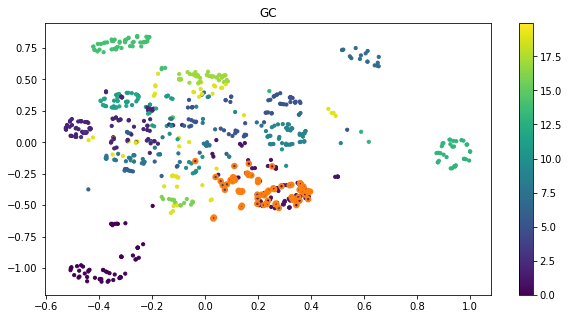

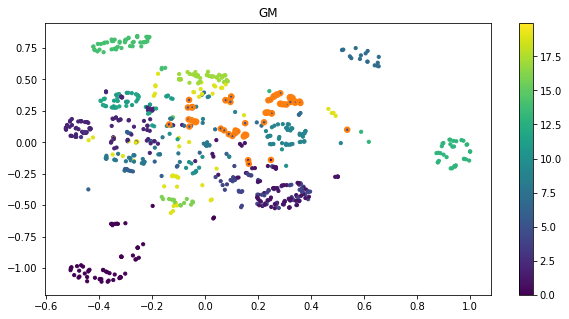

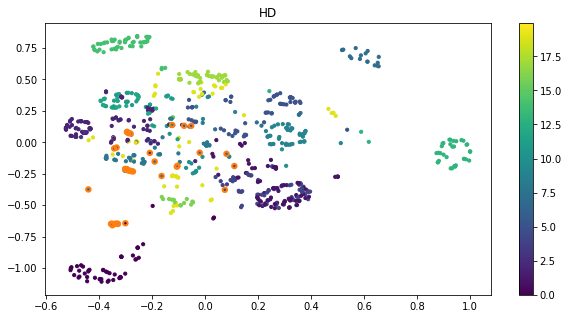

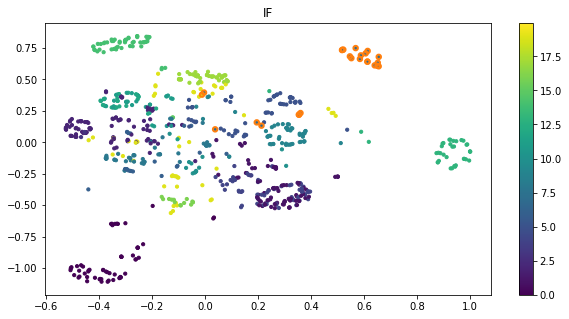

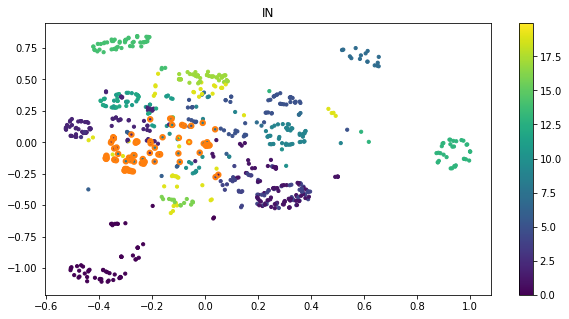

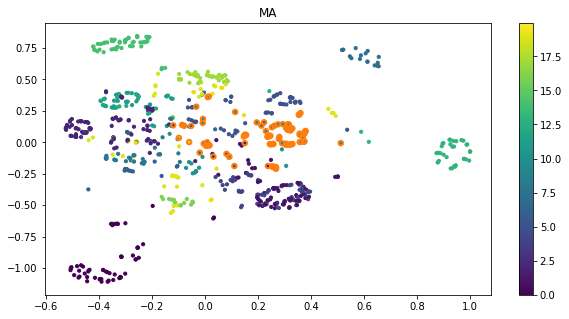

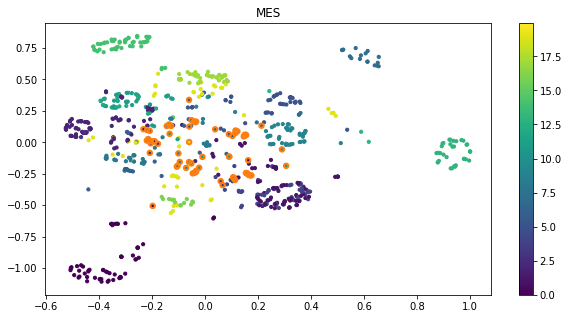

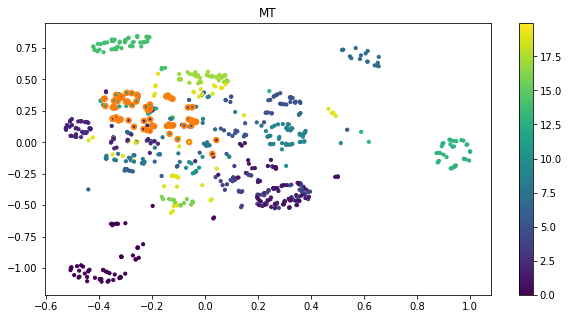

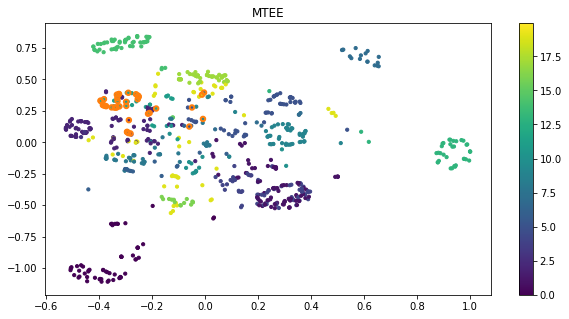

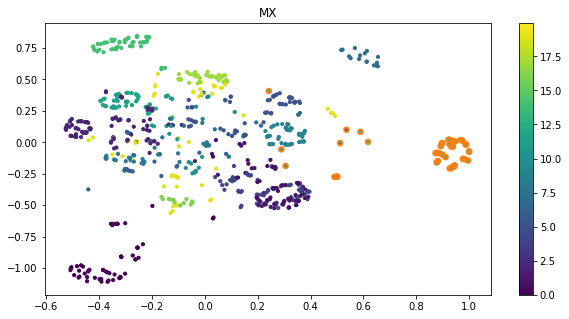

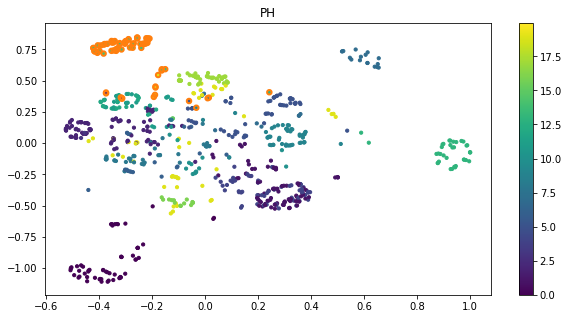

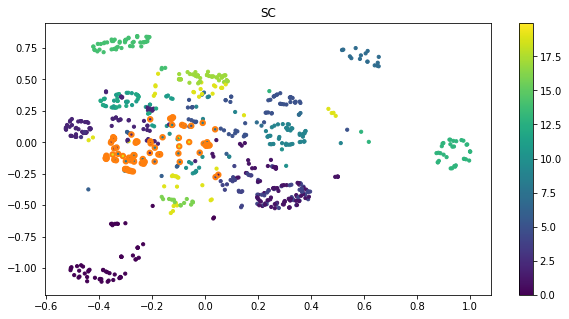

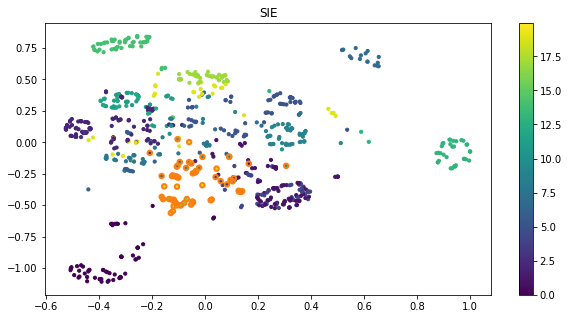

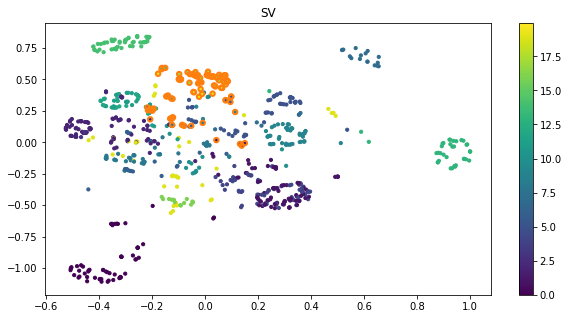

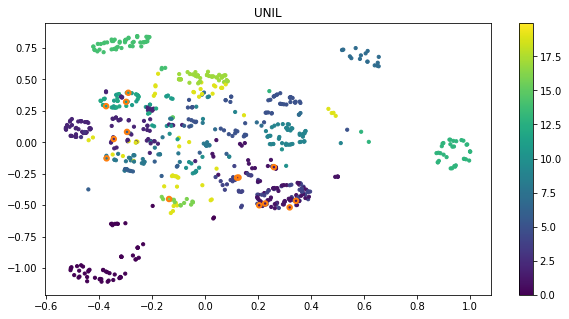

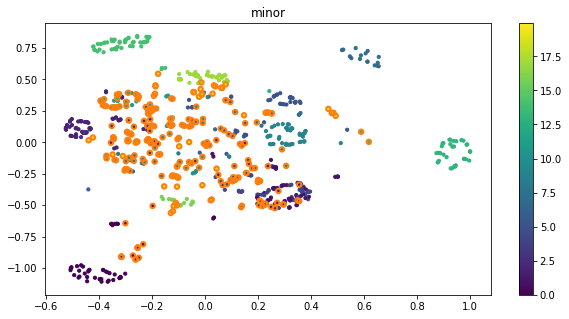

In [62]:
## Study plan
for i in tqdm(range(len(StudyPlansDisplay))):
    plt.figure()
    H.plot_signal(id_courses_sections_labelAR[:,0],show_edges=False, vertex_size=10,plot_name=StudyPlansDisplay[i] , save_as="Graphs/image/section_"+StudyPlansDisplay[i]+"_studyPlan_wAR_spring", highlight=np.where(np.isin(id_courses_sections_labelAR,[i]).any(axis=1)))

size of giant component: 798


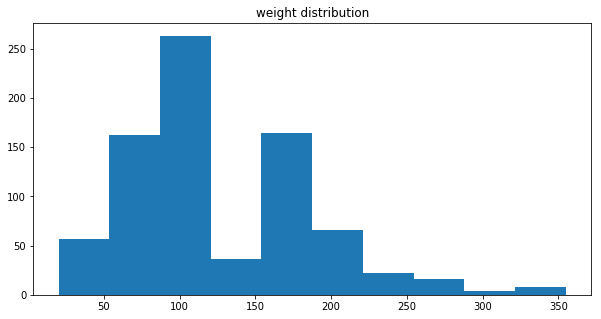

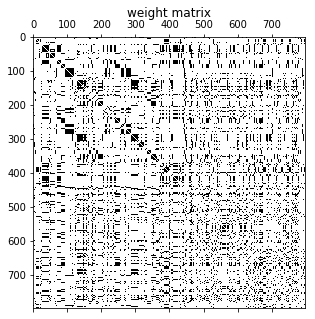

In [63]:
showAndSaveData(weight_section_AR,"section_AR")

### 2.2.5 Graphs profs - Master STI

c:\python35\lib\site-packages\pygsp\graphs\graph.py:606: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.W.sum(1), -0.5)


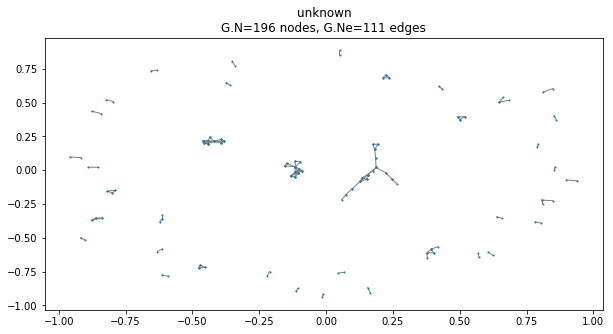

In [64]:
I=graphs.Graph(weight_prof_STI)
I.compute_laplacian("normalized")
#I.compute_fourier_basis(recompute=True)
I.set_coordinates()#H.U[:,1:3])
I.plot(vertex_size=10)#show_edges=True, vertex_size=10)

 50%|█████████████████████████████████████████                                         | 10/20 [00:02<00:02,  3.61it/s]c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.70it/s]


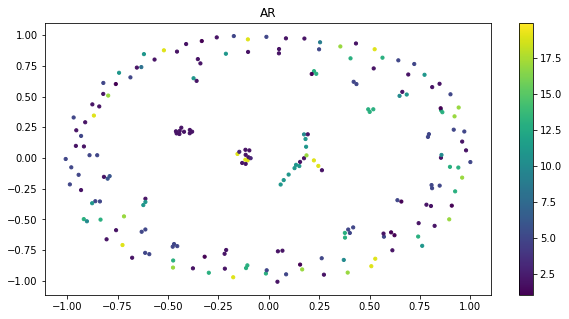

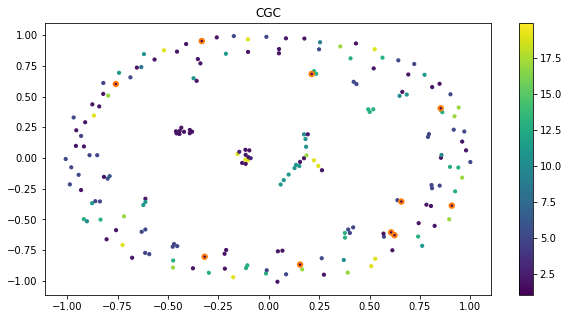

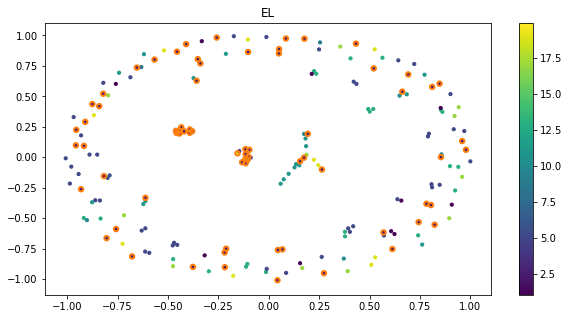

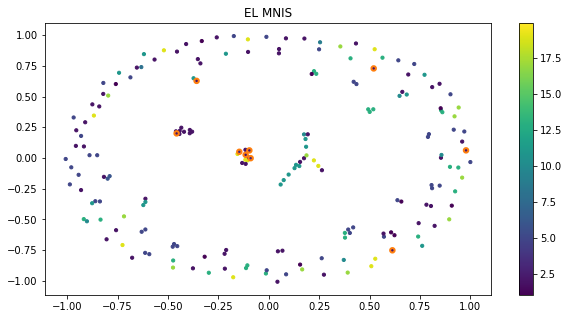

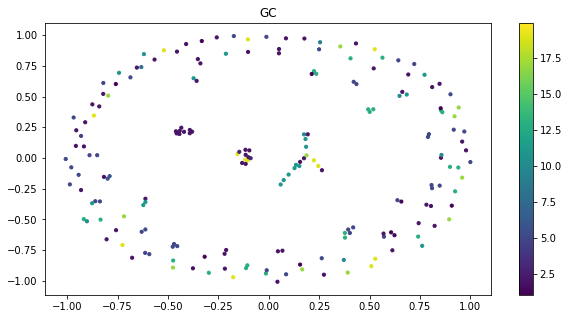

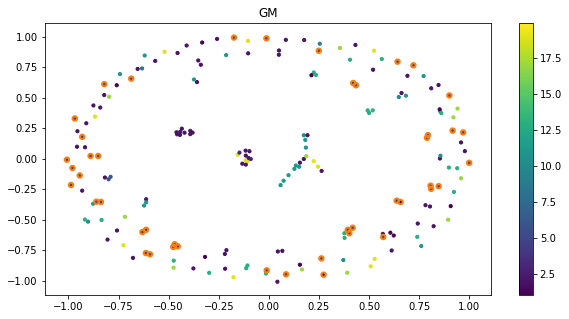

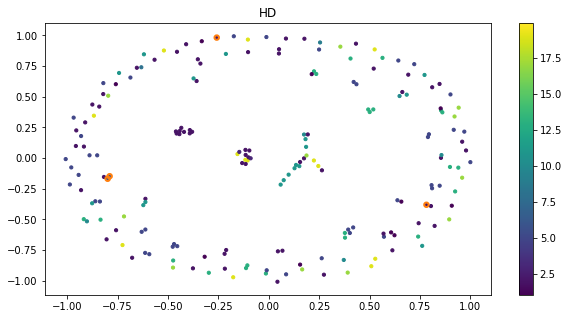

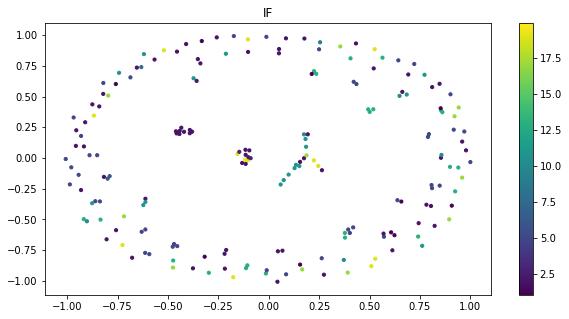

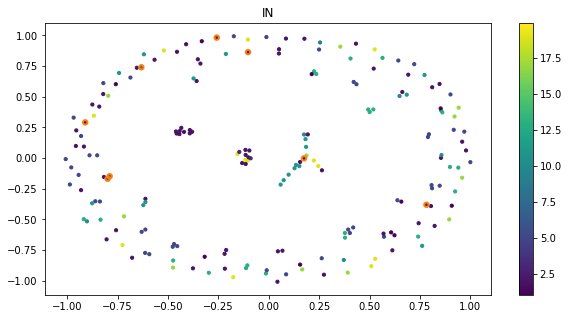

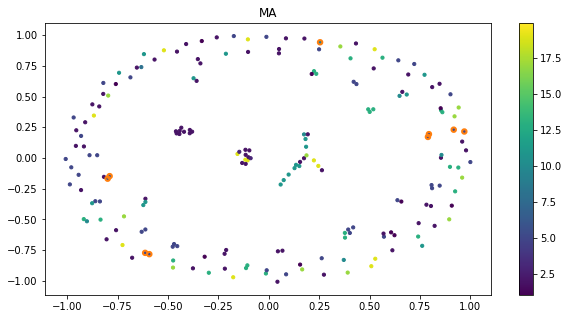

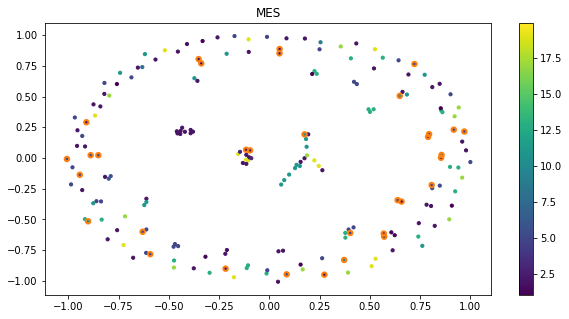

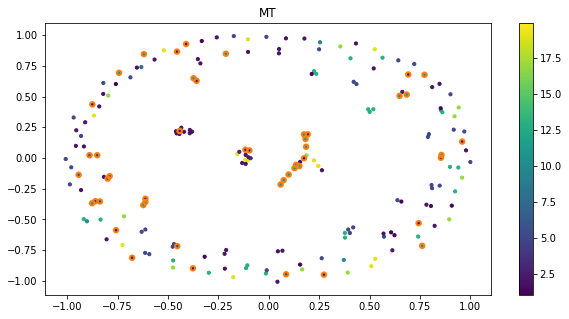

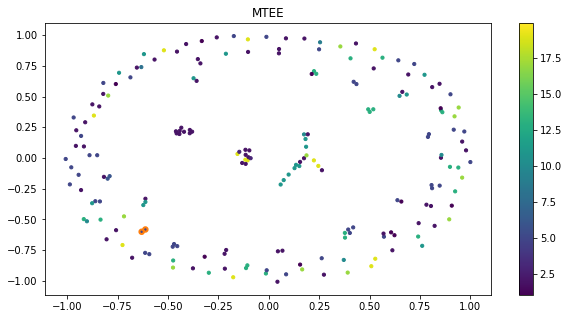

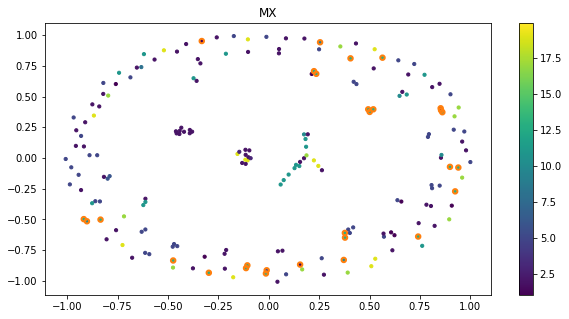

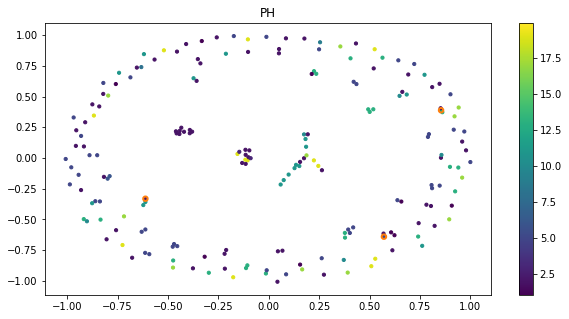

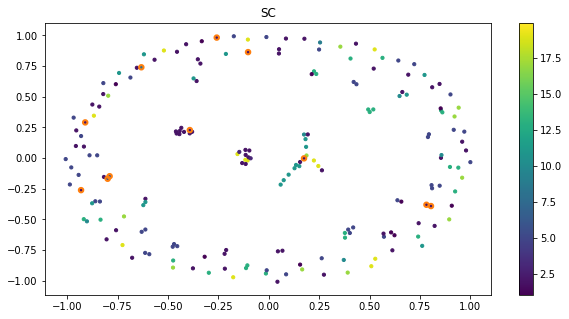

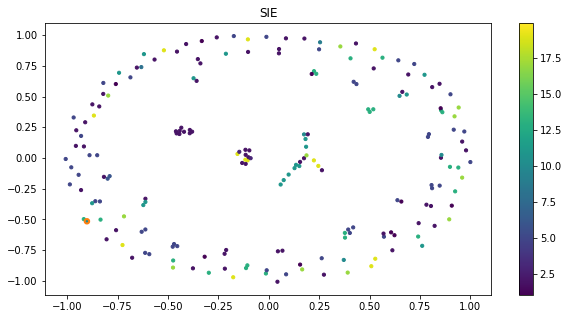

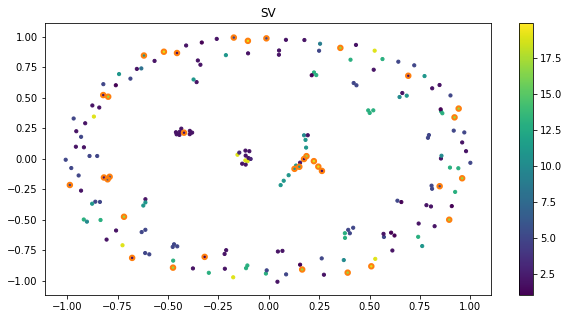

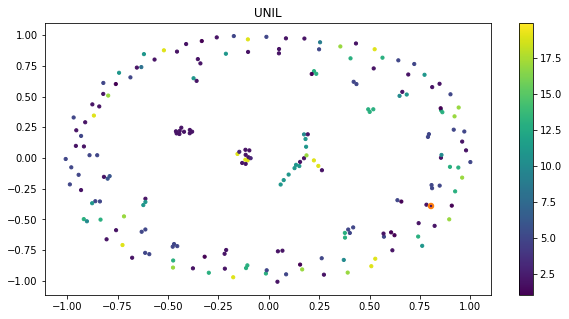

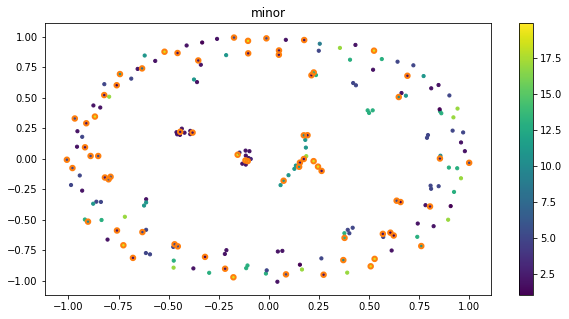

In [65]:
## Study plan
for i in tqdm(range(len(StudyPlansDisplay))):
    plt.figure()
    I.plot_signal(id_courses_sections_labelSTI[:,0],show_edges=False, vertex_size=10,plot_name=StudyPlansDisplay[i] , save_as="Graphs/image/profs_"+StudyPlansDisplay[i]+"_studyPlan_wSTI", highlight=np.where(np.isin(id_courses_sections_labelSTI,[i]).any(axis=1)))

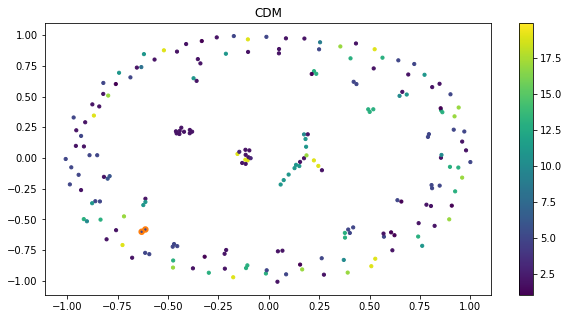

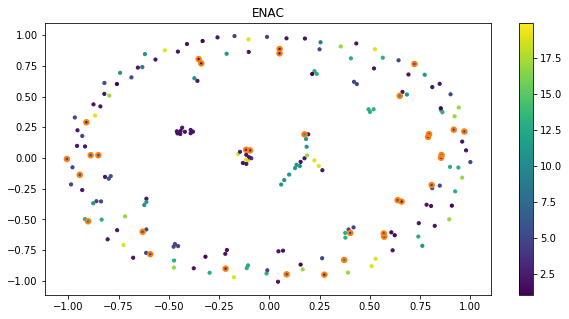

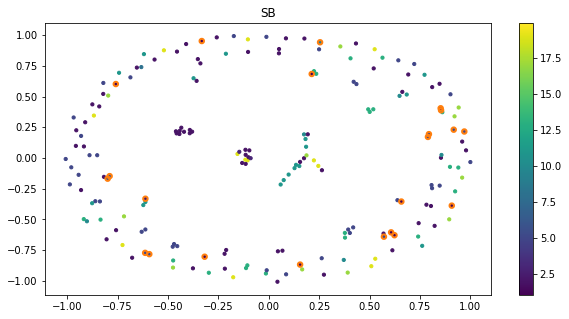

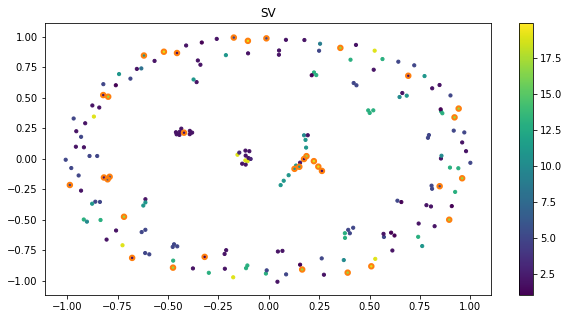

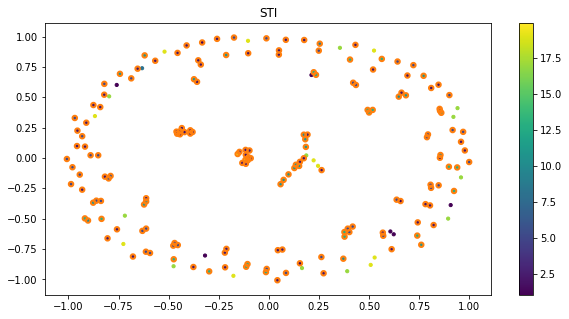

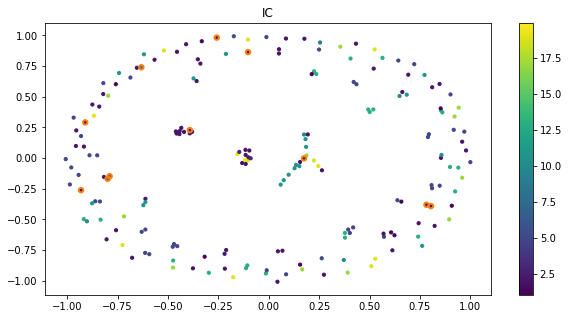

In [67]:
# faculty
for fac,ids in faculties.items():
    plt.figure()
    I.plot_signal(id_courses_sections_labelSTI[:,0],show_edges=False, vertex_size=10,plot_name=fac, save_as="Graphs/image/profs_"+fac+"_faculty_STI" , highlight=np.where(np.isin(id_courses_sections_labelSTI,ids).any(axis=1)))

c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


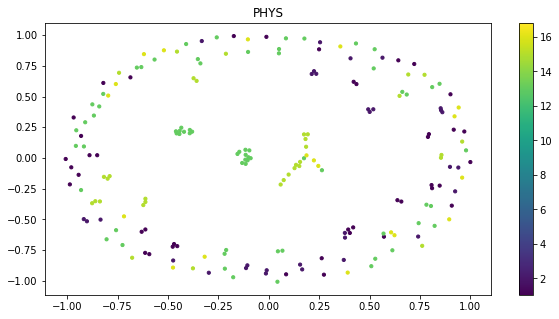

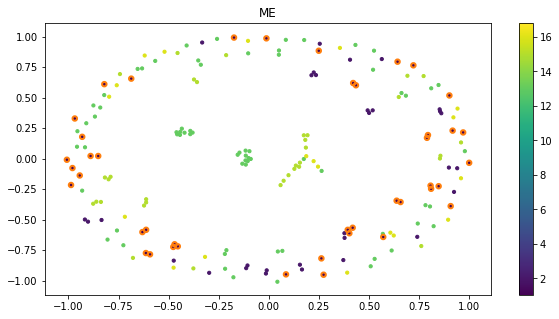

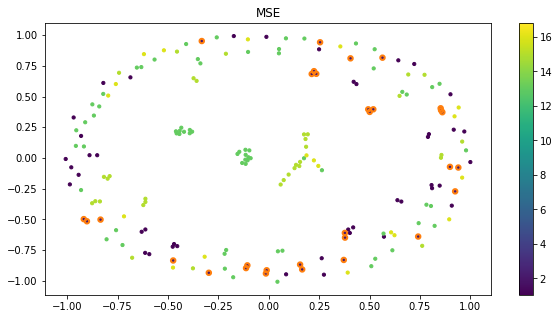

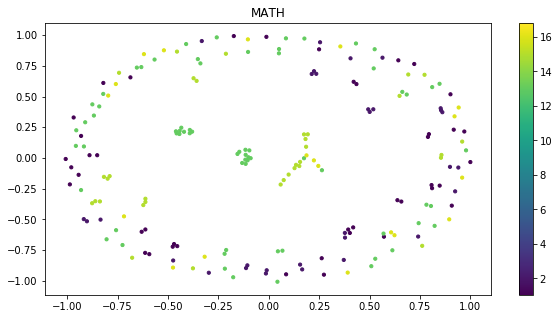

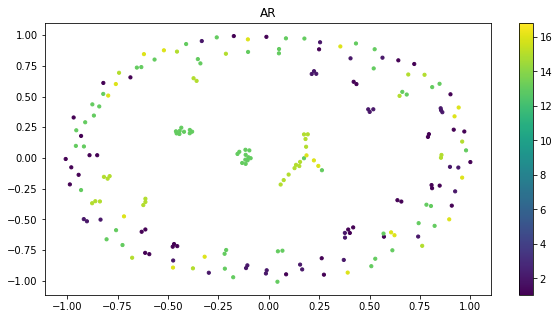

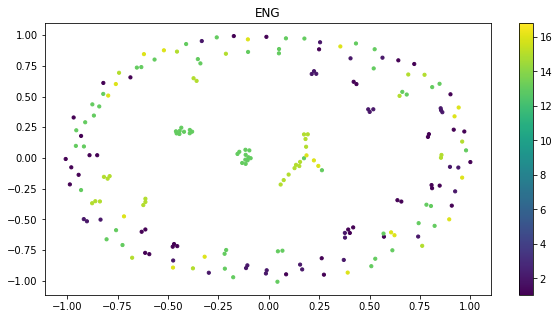

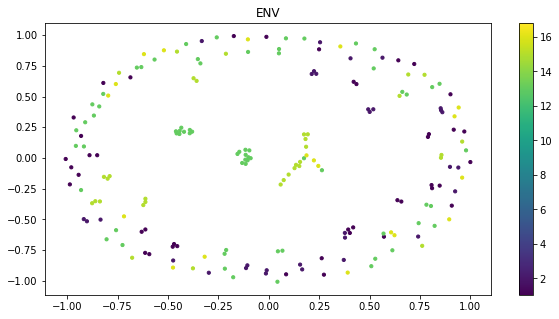

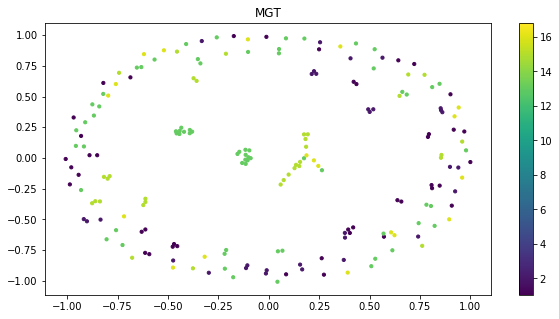

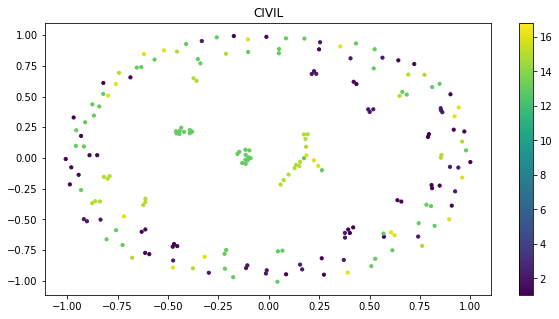

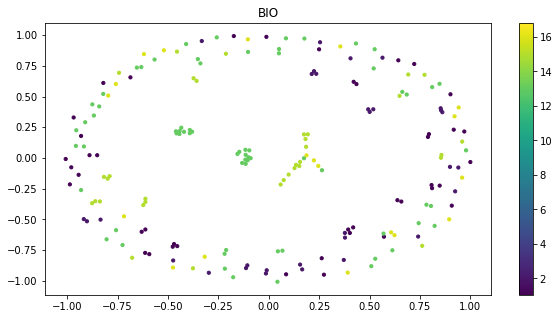

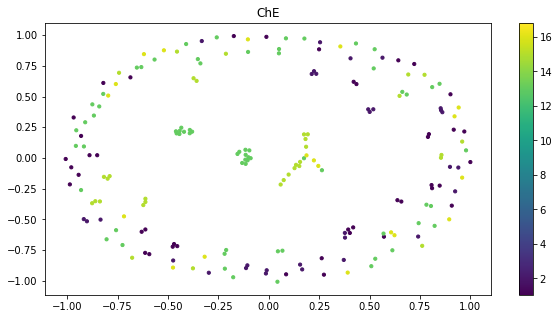

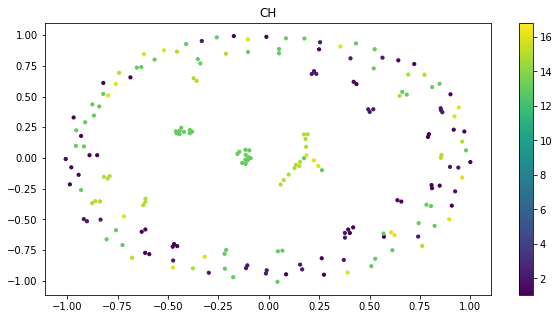

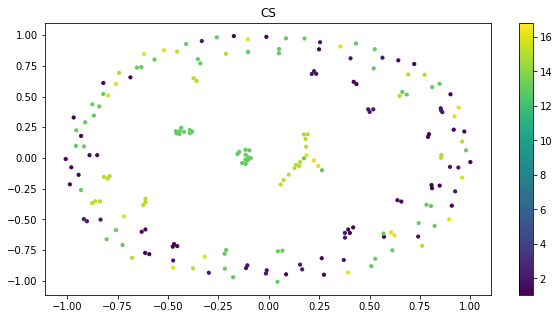

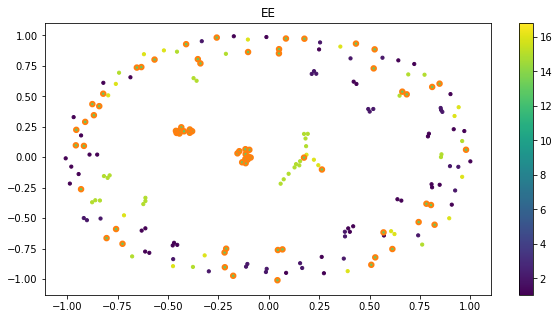

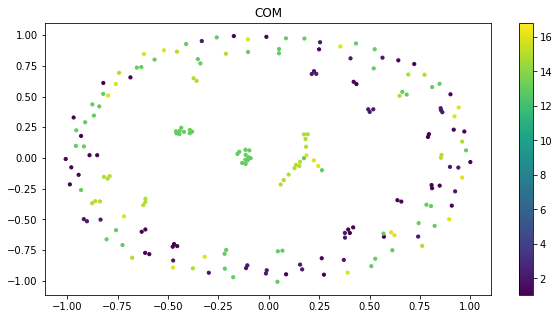

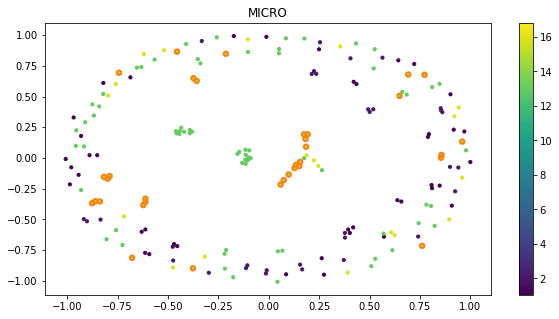

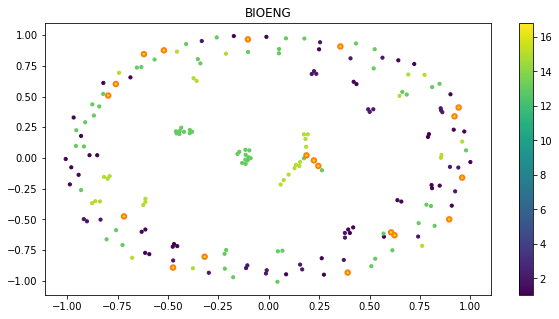

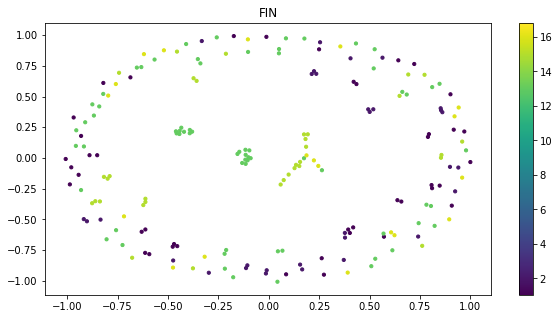

In [68]:
# sections
for i in range(len(courseSection)):
    plt.figure()
    I.plot_signal(id_courses_code_labelSTI,show_edges=False, vertex_size=10,plot_name=courseSection[i], 
                  save_as="Graphs/image/profs_"+courseSection[i]+"_section_STI", 
                  highlight=np.where(id_courses_code_labelSTI==i))

size of giant component: 16


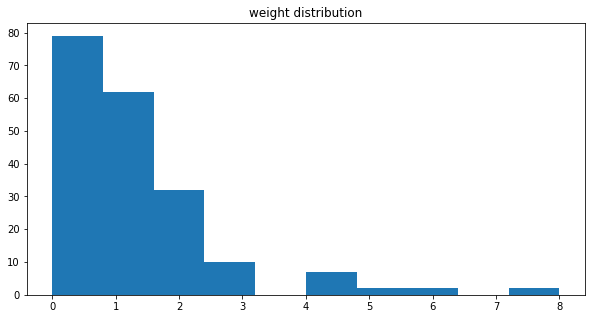

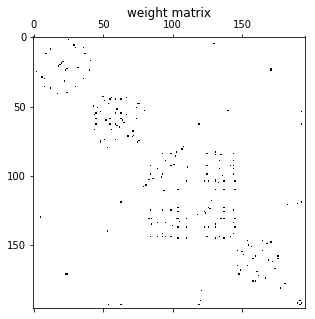

In [69]:
showAndSaveData(weight_prof_STI,"section_AR")

In [ ]:
# show list of courses in main component

### 2.2.6 Graph Assistants - Mater STI

c:\python35\lib\site-packages\pygsp\graphs\graph.py:606: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.W.sum(1), -0.5)


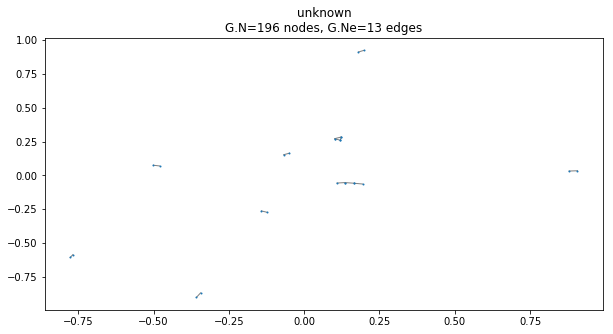

In [71]:
J=graphs.Graph(weight_assistants_STI)
J.compute_laplacian("normalized")
#I.compute_fourier_basis(recompute=True)
J.set_coordinates()#H.U[:,1:3])
J.plot(vertex_size=10)#show_edges=True, vertex_size=10)

 50%|█████████████████████████████████████████                                         | 10/20 [00:02<00:02,  3.68it/s]c:\python35\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:05<00:00,  3.84it/s]


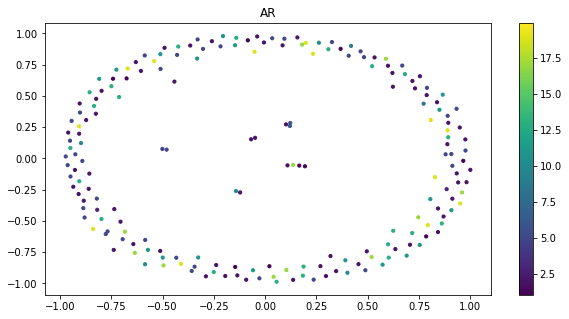

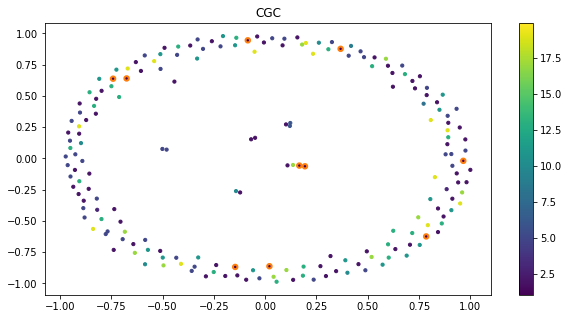

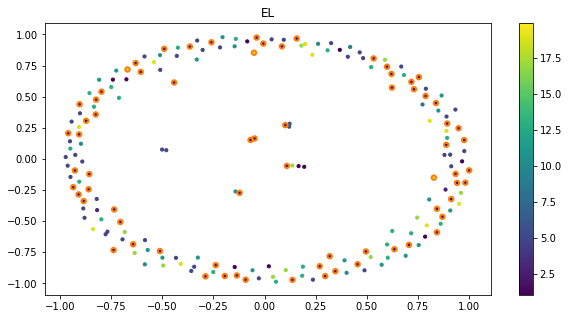

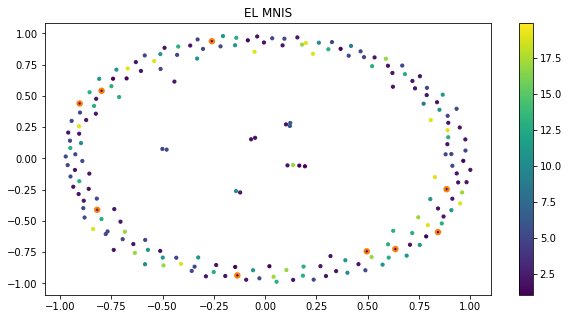

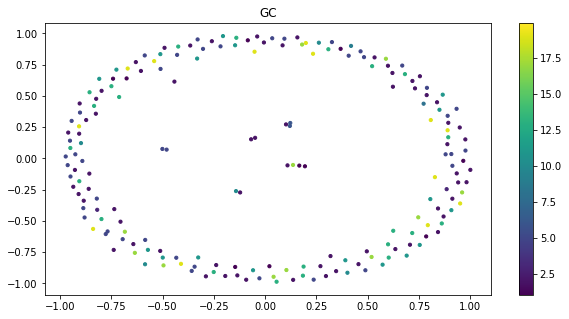

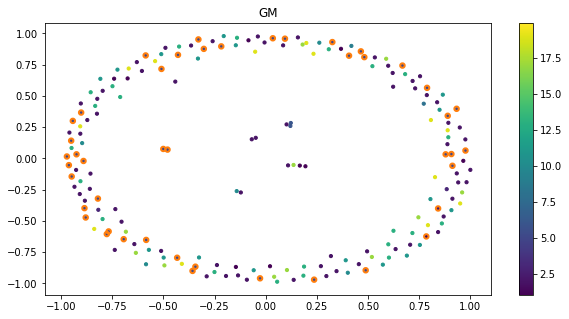

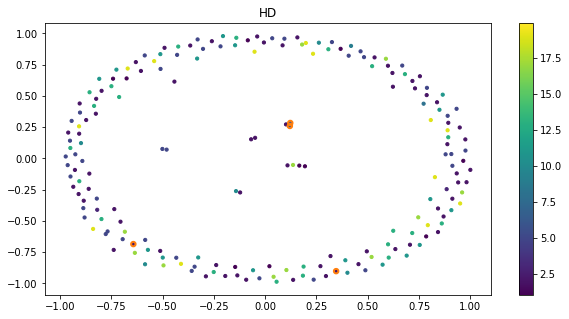

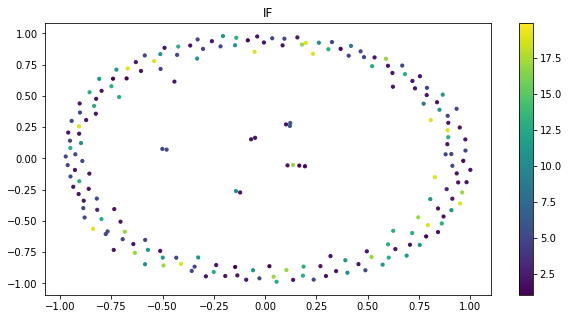

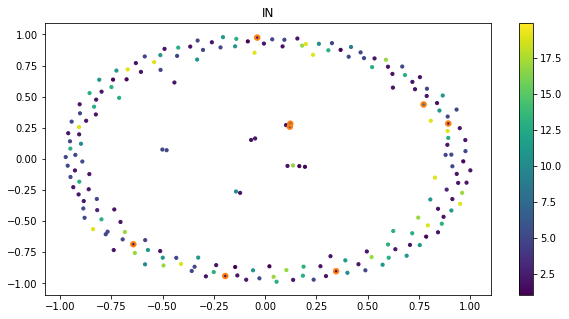

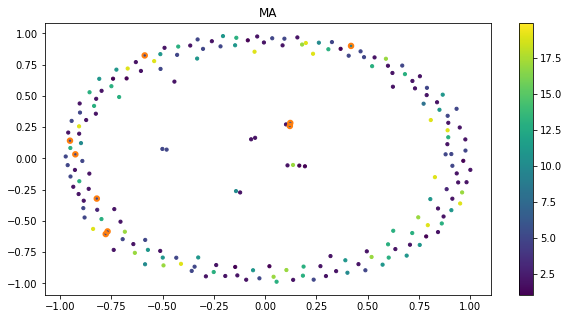

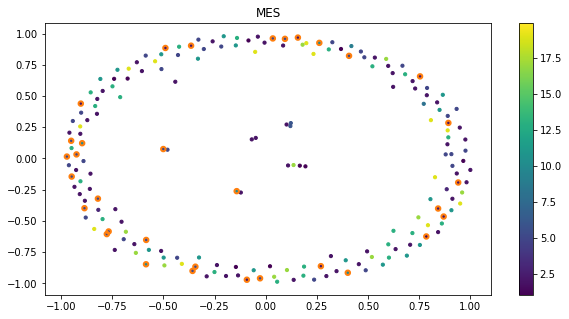

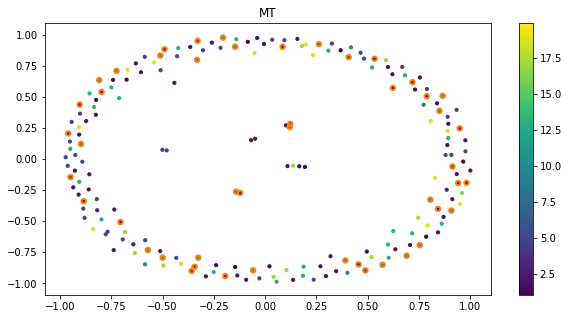

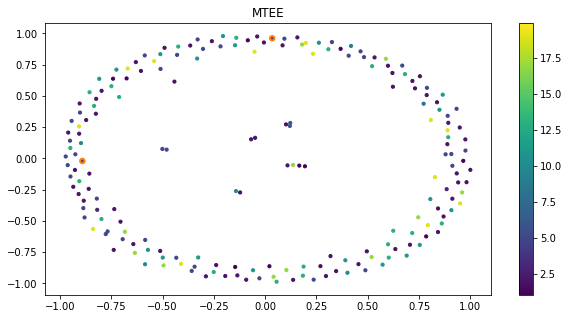

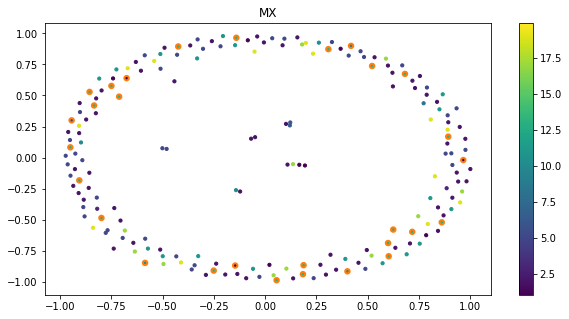

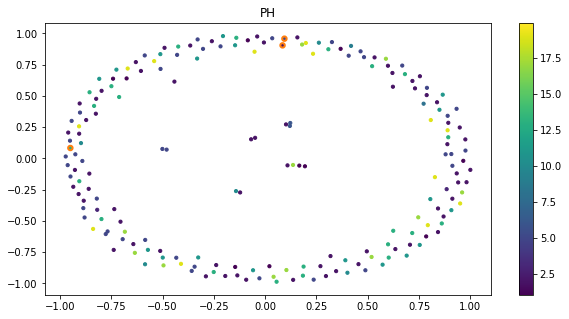

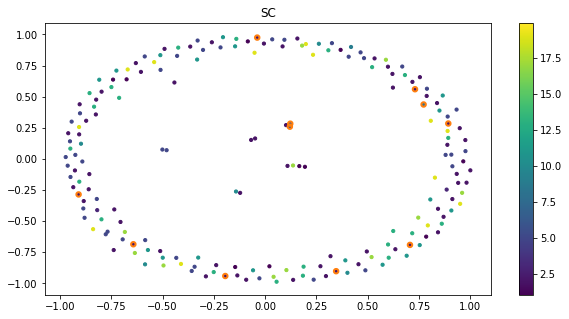

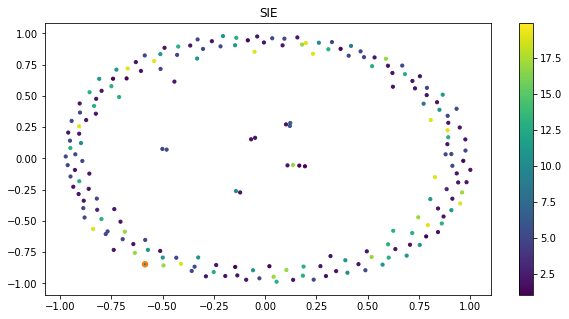

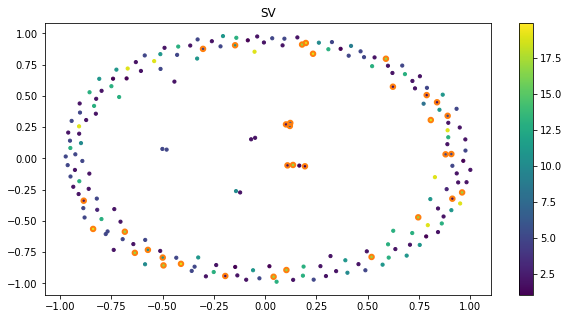

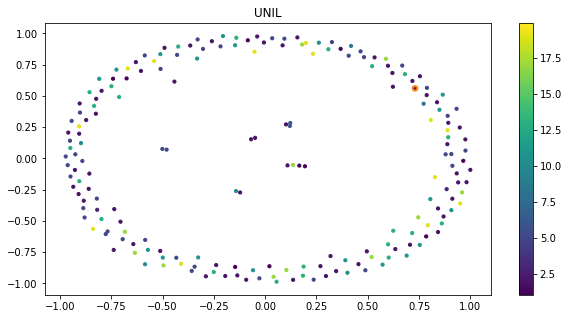

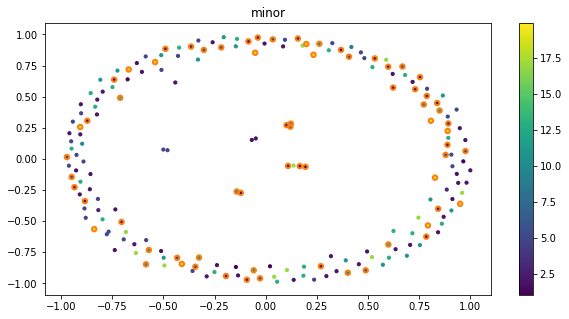

In [72]:
## Study plan
for i in tqdm(range(len(StudyPlansDisplay))):
    plt.figure()
    J.plot_signal(id_courses_sections_labelSTI[:,0],show_edges=False, vertex_size=10,plot_name=StudyPlansDisplay[i] , save_as="Graphs/image/assistants_"+StudyPlansDisplay[i]+"_studyPlan_wSTI", highlight=np.where(np.isin(id_courses_sections_labelSTI,[i]).any(axis=1)))

size of giant component: 4


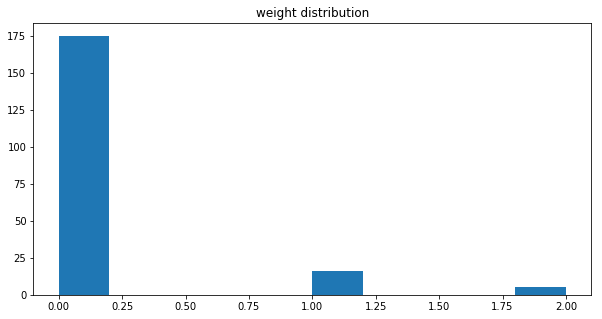

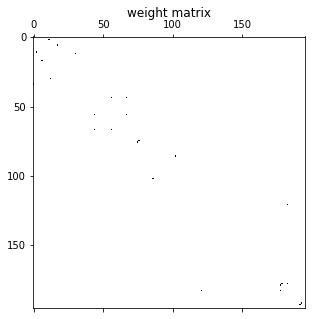

In [73]:
showAndSaveData(weight_assistants_STI,"ASSISTANT_AR")

### 2.2.7 Requirements Graphs

#### 2.2.7.1 requirement link graph

In [48]:
## courses are linked if one is a requirement of the other
pkl_file = open(os.path.join(os.getcwd(), 'Graphs','req_course_to_req_graph_STI.pkl'), 'rb')
weight_req_diff_level_STI = pickle.load(pkl_file)
pkl_file.close()

## courses are linked if they share the same requirements
pkl_file = open(os.path.join(os.getcwd(), 'Graphs','req_same_course_graph_STI.pkl'), 'rb')
weight_req_similar_STI = pickle.load(pkl_file)
pkl_file.close()

## courses are linked if they are the requirements of the same course
pkl_file = open(os.path.join(os.getcwd(), 'Graphs','req_course_same_req_graph_STI.pkl'), 'rb')
weight_req_same_level_STI = pickle.load(pkl_file)
pkl_file.close()

2018-01-21 20:11:28,667:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


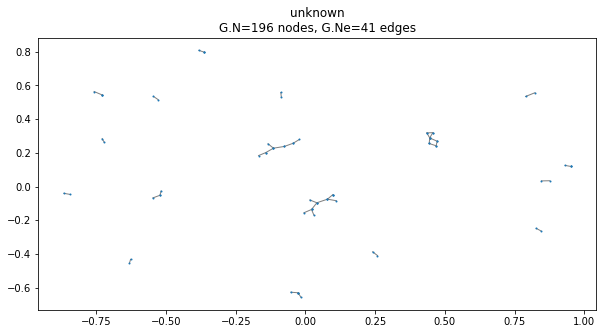

In [49]:
#weight_req_diff_level_STI = np.fill_diagonal(weight_req_diff_level_STI,0)
weight_req_diff_level_STI = weight_req_diff_level_STI
L=graphs.Graph(weight_req_diff_level_STI)
#L.compute_laplacian("normalized")
#L.compute_fourier_basis(recompute=True)
L.set_coordinates()#L.U[:,1:3])
L.plot(vertex_size=10)#show_edges=True, vertex_size=10)

size of giant component: 8


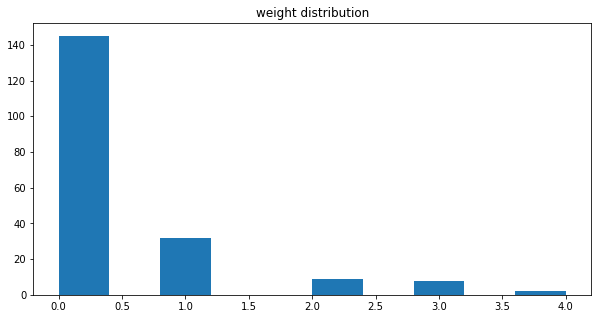

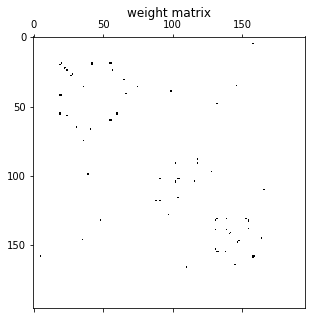

In [52]:
showAndSaveData(weight_req_diff_level_STI,"requirement_linked_weight")

#### 2.2.7.2 same requirement graph

C:\Users\Thomas\Anaconda3\lib\site-packages\pygsp\graphs\graph.py:606: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.W.sum(1), -0.5)


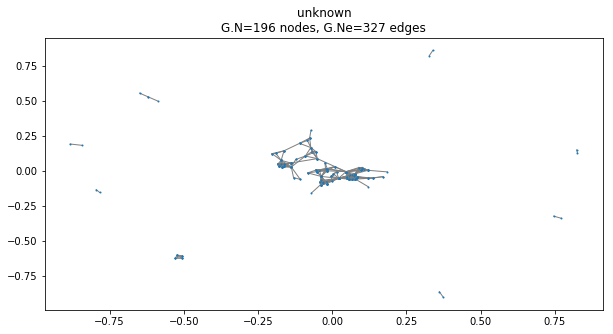

In [50]:
M=graphs.Graph(weight_req_similar_STI)
M.compute_laplacian("normalized")
#M.compute_fourier_basis(recompute=True)
M.set_coordinates()#M.U[:,1:3])
M.plot(vertex_size=10)#show_edges=True, vertex_size=10)

size of giant component: 73


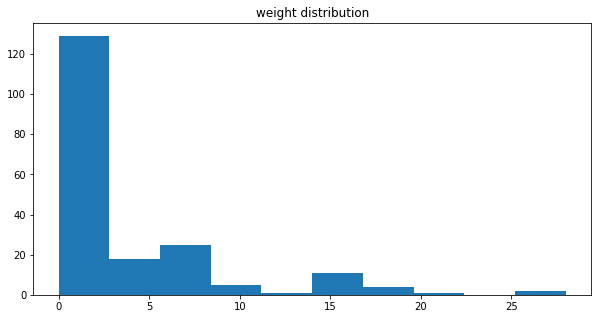

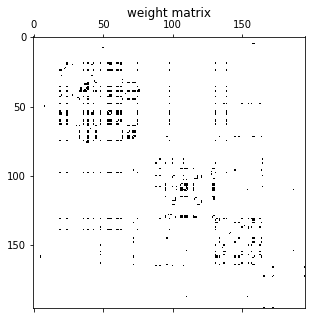

In [53]:
showAndSaveData(weight_req_similar_STI,"req_same_course_graph_STI")

#### 2.2.8.3 is required graph

C:\Users\Thomas\Anaconda3\lib\site-packages\pygsp\graphs\graph.py:606: RuntimeWarning: divide by zero encountered in power
  d = np.power(self.W.sum(1), -0.5)


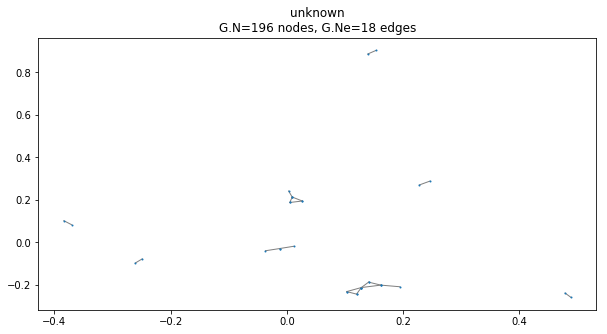

In [51]:
N=graphs.Graph(weight_req_same_level_STI)
N.compute_laplacian("normalized")
#N.compute_fourier_basis(recompute=True)
N.set_coordinates()#N.U[:,1:3])
N.plot(vertex_size=10)#show_edges=True, vertex_size=10)

size of giant component: 6


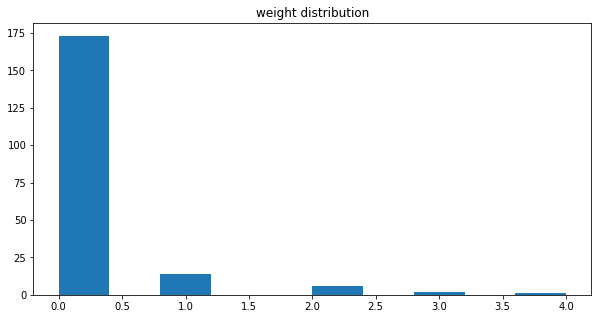

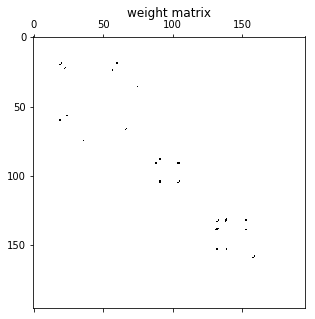

In [54]:
showAndSaveData(weight_req_same_level_STI,"req_course_same_req_graph_STI")